# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

The goals of this project are the following:

<ul>
<li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
<li>Apply a distortion correction to raw images.
<li>Use color transforms, gradients, etc., to create a thresholded binary image.
<li>Apply a perspective transform to rectify binary image (birds-eye view).
<li>Detect lane pixels and fit to find the lane boundary.
<li>Determine the curvature of the lane and vehicle position with respect to center.
<li>Warp the detected lane boundaries back onto the original image.
<li>Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
</ul>

---

## Import Packages

In [2]:
### Importing necessary packages

import numpy as np                  # For handling images
import glob                         # For iterating through multiple image files
import cv2                          # For image manipulation
import matplotlib.pyplot as plt     # For plotting images

# For plotting to display inline within the notebook
%matplotlib inline

print("All package import complete")

All package import complete


## Define Global Variables

In [68]:
### Global variables and constants defined here

detected_lines = []                  # Global variable to hold all detected lines
reset_lanes = True                   # Flag that drives detection of fresh lanes
terrain_type = None                  # Variable that indicates the terrain type
mtx = dist = None                    # Camera caliberation parameters
perspective_M = perspective_Minv = None  # Perspective and inverse perspective
baseline_lane_width = None           # Baseline lane width in px calculated from reference image
cb = np.empty([360,1930,3])          # Holding variable for image concatenation        
c1 = np.empty([370,640,3])           # Holding variable for image concatenation
c2 = np.empty([360,640,3])           # Holding variable for image concatenation

class Line():                        # Objects of this Line class hold details of a detected lines
    def __init__(self):

        self.fresh_lane = None
        self.good_lane = None
        self.continous_bad_lanes = 0
        self.leftx_base = None
        self.rightx_base = None
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        self.left_fit = None
        self.right_fit = None
        self.left_curverad = None
        self.right_curverad = None
        self.center_offset_m = None
        self.lane_width = None
        self.smooth_leftx_base = 0
        self.smooth_rightx_base = 0
        self.smooth_left_fit = [0,0,0]
        self.smooth_right_fit = [0,0,0]

print("All global variable definition complete")

All global variable definition complete


## Define support functions

The helper functions needed for this project are defined in this section

In [87]:
### Support Functions

""" The helper functions needed to identify lanes are defined in this section """

def showImg(img):
    """ Combines plt.imshow() and plt.show() so that
        grayscale images can be displayed with a single line funtion call"""
    plt.imshow(img)
    plt.show()
    return

def showGrayImg(img):
    """ Combines plt.imshow() and plt.show() so that 
        images can be displayed with a single line funtion call"""
    plt.imshow(img, cmap="gray")
    plt.show()
    return

def undistort(img):
    """ Undistorts a given image using 
        Camera caliberations"""
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    """Applies the Grayscale transform
       This will return an image with only one color channel"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gradient(gray, orient, sobel_kernel, thresh):
    """ Calculates directional gradient in the required orientation
        Applies threshold"""
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def gradient_mag(gray, sobel_kernel, mag_thresh):
    """ Calculates gradient magnitude
        Applies threshold"""

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt( (sobelx*sobelx) + (sobely*sobely) )
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def gradient_dir(gray, sobel_kernel, dir_thresh):
    """ Calculates gradient direction
        Applies threshold"""
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
#    scaled_dir_grad = np.uint8(255*dir_grad/np.max(dir_grad))
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
    return dir_binary

def s_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_s = img[:,:,2]

    sbinary = np.zeros_like(img_s)
    sbinary[(img_s > thresh[0]) & (img_s <= thresh[1])] = 1
    return sbinary

def l_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_l = img[:,:,1]

    lbinary = np.zeros_like(img_l)
    lbinary[(img_l > thresh[0]) & (img_l <= thresh[1])] = 1
    return lbinary

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    global terrain_type
    
    if terrain_type == 'h':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 360
        mask_top_right_x = 680
        mask_bottom_right_x = 1190
        mask_bottom_left_x = 75
    elif terrain_type == 'c':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 580
        mask_top_right_x = 750
        mask_bottom_right_x = 1150
        mask_bottom_left_x = 180
    else:
        mask_top_y = 440
        mask_bottom_y = 720
        mask_top_left_x = 530
        mask_top_right_x = 740
        mask_bottom_right_x = 1165
        mask_bottom_left_x = 150
        
    
    vertices = np.array([[(mask_top_left_x, mask_top_y), (mask_top_right_x, mask_top_y),  \
                          (mask_bottom_right_x, mask_bottom_y), (mask_bottom_left_x, mask_bottom_y)]],  \
                             dtype=np.int32) # vertices of the masked area

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

def calculate_curvature(y_eval, fit):
    """Calculates the radius of curvature of a given line"""
    # y_eval : y-value where we want radius of curvature
    # fit : left or right line fit
    return ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

def img_collage(marked_img):
    """ Concatenate images into a single image
        This helps view different perspectives of the image
        at the same time helping with debugging"""
    global c1, c2
    c3 = np.concatenate((c1,c2),0)
    marked_img = cv2.resize(marked_img,(1280, 720))
    c0 = cv2.copyMakeBorder(marked_img,0,10,0,10,cv2.BORDER_CONSTANT, value=[255,255,0])
    ct = np.concatenate((c0,c3),1)
    c = np.concatenate((ct,cb),0)
    c = cv2.resize(c,(1280, 720))
    return c

## Extract warped binary image of the lanes

This function takes in a 3 channel RGB color image and returns a warped binary image with the lane markings only

In [67]:
### Function to extract a warped binary image of the lanes

""" This function takes in a 3 channel RGB olor image and 
    returns a warped binary image with the lane markings only """

    # Undistort the image
    # Create necessary color channel filters
    # Create necessary sobel filters
    # Create a combined filter that provides the best results
    # Apply mask to pick up lane pixels only
    # Warp the image

def get_binary_warp(image):

    # Undistort the camera image
    image = undistort(image)
    
    # Get image filtered by S channel
    s_chn_img = s_select(image, thresh=(100,255))
    
    # Get image filtered by L channel
    l_chn_img = l_select(image, thresh=(50,255))
    
    # Grayscale the image
    gray_img = grayscale(image)
    
    # Get image filtered by sobel x
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel y
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel magnitude
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    
    # Get image filtered by sobel gradient direction
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
    combined_img = np.zeros_like(sobelx_img)
    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    # Pick up pixels that have high S and L channel values.  This will help address shadow conditions
    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    
    # Pick up pixels that have high sobel x and y values.  This will help pick only strong pixels.
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1

    # Combine the two binary images.  This image :
    # 1. Will capture lanes under shadows as well
    # 2. Will pick up only strong pixels that have high values both in x and y
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
    
    """
    # Use Hough transform to filter out non-line pixels and horizontal lines
    lines = hough_lines(combined_img4, 2, np.pi/180, 100, 30, 20)
    #creating a blank to draw lines on
    line_image = np.copy(image)*0
    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)
            if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((combined_img4, combined_img4, combined_img4)) 
    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    showImg(combo)
    """

    # Apply mask for lane region only to filter out non-lane pixels.
    masked_image = region_of_interest(combined_img4) 
    
    # Warp the image to provide a top down perspective view
    warped_image = cv2.warpPerspective(masked_image, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)
#    showGrayImg(warped_image)

    """
    # Plot the images for review
    f = plt.figure(figsize=(30, 18))
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(s_chn_img, cmap='gray')
    ax2.set_title('S Channel', fontsize=10)
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(l_chn_img, cmap='gray')
    ax3.set_title('L Channel', fontsize=10)
    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(sobelx_img, cmap="gray")
    ax4.set_title('Gradient x', fontsize=10)
    ax5 = plt.subplot(2, 4, 5)
    ax5.imshow(sobely_img, cmap="gray")
    ax5.set_title('Gradient y', fontsize=10)
    ax6 = plt.subplot(2, 4, 6)
    ax6.imshow(combined_img, cmap="gray")
    ax6.set_title('Combined Image', fontsize=10)
    ax7 = plt.subplot(2, 4, 7)
    ax7.imshow(warped_image, cmap="gray")
    ax7.set_title('Warped View', fontsize=10)
    ax8 = plt.subplot(2, 4, 8)
    ax8.imshow(masked_image, cmap="gray")
    ax8.set_title('Masked View', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    f.savefig('Inflight_' + str(idx))
    plt.show()
    """
    
    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    c4 = cv2.resize(combined_img,(640, 360))
    c4 = np.dstack((c4, c4, c4))*255
    c4 = cv2.copyMakeBorder(c4,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c4,"Filtered Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
#    print("c4 shape = ", c4.shape)
    c5 = cv2.resize(masked_image,(640, 360))
    c5 = np.dstack((c5, c5, c5))*255
    c5 = cv2.copyMakeBorder(c5,0,0,0,5,cv2.BORDER_CONSTANT, value=[0,0,0])
    cv2.putText(c5,"Masked Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255255,255))
#    print("c5 shape = ", c5.shape)
    c6 = cv2.resize(warped_image,(640, 360))
    c6 = np.dstack((c6, c6, c6))*255
    c6 = cv2.copyMakeBorder(c6,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c6,"Warped", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    cv2.putText(c6,"Image", (150,60), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
#    print("c6 shape = ", c6.shape)
    global cb
    cb = np.concatenate((c4, c5, c6),1)

    return warped_image

## Detect fresh left and right lanes a warped binary image

This function takes in a warped binary image of the lanes and detects the lanes.  This function is used during the start of the pipeline and whenever multiple bad lines are detected continously

In [11]:
### This function will locate a fresh set of lane lines from a given binary warped image
"""  This function called 
     1. During the start of the pipeline to find the lanes
     2. Whenever continous bad lanes are detected - this will help as a reset"""

def find_fresh_lanes(binary_warped):
    
    print("Inside reset")
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
#    plt.plot(histogram)
#    plt.show()
    

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#    print(leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    global c2
    c2 = cv2.resize(out_img,None,fx=0.5, fy=0.5)
    c2 = cv2.copyMakeBorder(c2,0,10,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    showImg(c2)
 
    # Reset the flag to indicate that fresh detection has been done
    global reset_lanes
    reset_lanes = False
    
#    showImg(out_img)

    return leftx_base, rightx_base, left_lane_inds, right_lane_inds
    

## Perform sanity check on lane lines

This function performs sanity checks on the identified lane lines and decides if they are high confidence detections

In [12]:
### Perform sanity checks.
""" 1. Sanity check the left and right lanes from the current detection.
    2. Sanity check the lanes against previous good values for continuity """

def sanity_check_lanes(l):
    
    good_lane = True
    
    while True:

        # Low Pass Filter - Do the left and rigth lanes have enough pixels
        if len(l.leftx) < 20 or len(l.rightx) < 20:
            good_lane = False
            print("@", len(detected_lines),  " > low pass failure : ", len(l.leftx), len(l.rightx) )
            break

        # Is the lane width reasonable (around 3.7 m)
        if not(3 < l.lane_width < 4.2):
            good_lane = False
            print("@", len(detected_lines),  " > lane width failure : ", l.lane_width)
            break

        # Are the lane curvatures reasonable
        if l.left_curverad > 20000 or l.right_curverad > 20000:
            good_lane = False
            print("@", len(detected_lines),  " > curve check failure : ", l.left_curverad, l.right_curverad)
            break

        # Do the left and right lanes have similar curvature
        if abs(l.left_curverad - l.right_curverad) > 10000:
            good_lane = False
            print("@", len(detected_lines),  " > left and right curves similarity failure : ", l.left_curverad, l.right_curverad)
            break
            
        # Are the lanes parallel (co-eff check)
#        if abs(l.left_fit[0] - l.right_fit[0]) > abs(0.75 * l.left_fit[0]):
        if abs(l.left_fit[0] - l.right_fit[0]) > 0.0005:
            good_lane = False
            print("@", len(detected_lines),  " > 2nd order coefficient similarity failure : ", l.left_fit[0], l.right_fit[0])
            break
            
#        if abs(l.left_fit[1] - l.right_fit[1]) > abs(0.75 * l.left_fit[1]):
        if abs(l.left_fit[1] - l.right_fit[1]) > 0.35:
            good_lane = False
            print("@", len(detected_lines),  " > 1st order coefficient similarity failure : ", l.left_fit[1], l.right_fit[1])
            break
        
        if not l.fresh_lane:
            
            # Is the lane offset marginal from prev frame
                if abs(l.center_offset_m - detected_lines[-1].center_offset_m) > 0.5:
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - lane offset variation high : ", 
                          l.center_offset_m, detected_lines[-1].center_offset_m)
                    break

            # Is the left curvature offset reasonable from prev frame
                if abs(l.left_curverad - detected_lines[-1].left_curverad) > abs(3.0 * l.left_curverad):
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - left curve variation high : ", 
                          l.left_curverad, detected_lines[-1].left_curverad)
                    break
            
            # Is the right curvature offset reasonable from prev frame
                if abs(l.right_curverad - detected_lines[-1].right_curverad) > abs(3.0 * l.right_curverad):
                    good_lane = False
                    print("@", len(detected_lines),  " > Continuity check failed - right curve variation high : ", 
                          l.right_curverad, detected_lines[-1].right_curverad)
                    break

            # Is the co-eff offset reasonable from prev frame
            
        break
            
#    print("lane quality = ", good_lane)
    return good_lane

## Extract left and right lane fits from a warped binary image

This function takes in a warped binary image of the lanes and returns the left and right lane fits

In [13]:
### Function to extract the left and right line fits from a given warped binary image of the lanes

""" This function takes in a warped binary image of the lanes and 
    returns the left and right lane fits """

def get_line_fits(binary_warped):
    
#    showGrayImg(binary_warped)
    global reset_lanes
#    print('reset status', reset_lanes)

    # Identify indices of non-zero pixels from the binary image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create a new Line object to store the lane parameters
    l = Line()
    
    if reset_lanes :
        # Fresh lanes being built
        leftx_base, rightx_base, left_lane_inds, right_lane_inds = find_fresh_lanes(binary_warped)
        l.fresh_lane = True
    else:
        # Using coeff from last good detection for plotting new lanes
        l.fresh_lane = False
        margin = 100
        left_fit = detected_lines[-1].left_fit
        right_fit = detected_lines[-1].right_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        y_base = binary_warped.shape[0]
        leftx_base = left_fit[0]*(y_base**2) + left_fit[1]*y_base + left_fit[2]
        rightx_base = right_fit[0]*(y_base**2) + right_fit[1]*y_base + right_fit[2]
#        print(leftx_base, rightx_base)


    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#    showImg(out_img)

    # Fit a second order polynomial to each lane
    if len(leftx) == 0 or len(lefty) == 0:
        leftx = detected_lines[-1].leftx
        lefty = detected_lines[-1].lefty
    if len(rightx) == 0 or len(righty) == 0:
        rightx = detected_lines[-1].rightx
        righty = detected_lines[-1].righty

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#    print("left fit =" , left_fit)
#    print("right fit =" , right_fit)


    # Calculate radius of curvature
    global baseline_lane_width
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty) / 2  # y-value where we want radius of curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension  -->  Manual observation
    xm_per_pix = 3.7/baseline_lane_width # meters per pixel in x dimension
#    xm_per_pix = 3.7/700 # meters per pixel in x dimension
#    ym_per_pix = 3/7 # meters per pixel in y dimension  -->  Manual observation


    # Calculate curvature in pixels
    left_curverad = calculate_curvature(y_eval, left_fit)
    right_curverad = calculate_curvature(y_eval, right_fit)
#    print("Curvature left = ", left_curverad, "px  right = ", right_curverad, "px")
    
    # Fit new polynomials to x,y in world space to calculate curvature in meters
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Determine lane width and offset
    lane_width = (rightx_base - leftx_base) * xm_per_pix
    lane_center = int(leftx_base + ((rightx_base - leftx_base) / 2))
    img_center = np.int(image.shape[1]/2)
    center_offset_px = img_center - lane_center
    center_offset_m = round((center_offset_px * xm_per_pix), 2)

    # Store detect lane parametes in the line object
    l.leftx_base = leftx_base
    l.rightx_base = rightx_base
    l.leftx = leftx
    l.lefty = lefty
    l.rightx = rightx
    l.righty = righty
    l.left_fit = left_fit
    l.right_fit = right_fit
    l.left_curverad = left_curverad
    l.right_curverad = right_curverad
    l.center_offset_m = center_offset_m
    l.lane_width = lane_width
    
    # Sanity check the identified lanes.
    if len(detected_lines) == 0:
        # Handle first clip of the pipeline
        l.good_lane = True
        l.continous_bad_lanes = 0
        l.smooth_left_fit = left_fit
        l.smooth_right_fit = right_fit
    else:
        l.continous_bad_lanes = detected_lines[-1].continous_bad_lanes
        l.good_lane = sanity_check_lanes(l)        

    # Create an image section that will show lane parameters
    # This makes it easy to debug
    global c1
    c1 = np.zeros_like(out_img)
    c1 = cv2.resize(c1,None,fx=0.5, fy=0.5)
    c1.fill(255)
    cv2.putText(c1,"Frame Metrics - " + str(len(detected_lines) + 1), (200,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lx_base = " + str(int(leftx_base)), (10,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rx_base = " + str(int(rightx_base)), (10,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"ln_width = " + str(round(lane_width,2)), (10,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit2 = " + str(round(left_fit[2],2)), (10,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit2 = " + str(round(right_fit[2],2)), (10,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit1 = " + str(round(left_fit[1],3)), (10,210), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit1 = " + str(round(right_fit[1],3)), (10,240), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit0 = " + str(round(left_fit[0],6)), (10,270), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit0 = " + str(round(right_fit[0],6)), (10,300), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Fresh Lane = " + str(l.fresh_lane), (300,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Good Lane = " + str(l.good_lane), (300,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Bad Lns = " + str(l.continous_bad_lanes), (300,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Left Curve = " + str(int(l.left_curverad)), (300,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Right Curve = " + str(int(l.right_curverad)), (300,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    c1 = cv2.copyMakeBorder(c1,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    print(c1.shape)
#    showImg(c1)

    # If the current lane detection is bad, use the previous good values to draw current lane
    if l.good_lane:
        l.continous_bad_lanes = 0
        i = 1
        # Smoothen the fit over the last n good detections
        for line in detected_lines[::-1]:
            l.smooth_left_fit += line.left_fit
            l.smooth_right_fit += line.right_fit
            if i == 5: 
                l.smooth_left_fit = l.smooth_left_fit / i
                l.smooth_right_fit = l.smooth_right_fit / i
                break 
            i += 1
    else:
        l.continous_bad_lanes += 1
        if l.continous_bad_lanes > 5: reset_lanes = True
        l.leftx_base = detected_lines[-1].leftx_base
        l.rightx_base = detected_lines[-1].rightx_base
        l.leftx = detected_lines[-1].leftx
        l.lefty = detected_lines[-1].lefty
        l.rightx = detected_lines[-1].rightx
        l.righty = detected_lines[-1].righty
        l.left_fit = detected_lines[-1].left_fit
        l.right_fit = detected_lines[-1].right_fit
        l.left_curverad = detected_lines[-1].left_curverad
        l.right_curverad = detected_lines[-1].right_curverad
        l.center_offset_m = detected_lines[-1].center_offset_m
        l.lane_width = detected_lines[-1].lane_width
        l.smooth_left_fit = detected_lines[-1].smooth_left_fit
        l.smooth_right_fit = detected_lines[-1].smooth_right_fit
    
    # Add the current lane lines to the detected_lines list
    detected_lines.append(l)

    return l

## Lane Marker Pipeline

This function acts as a pipeline that takes a 3 channel RGB color image as input and returns the same image with lanes marked in it.


In [54]:
### Lane Marker Pipeline
""" This function acts as a pipeline that takes a 3 channel RGB color image as input
    and returns the same image with lanes marked in it """

def lane_marker_pipeline(image):

    # Get the binary warped image of the input image
    binary_warped = get_binary_warp(image)
    
    # Identify the left and right fits from the binary warped image
    l = get_line_fits(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = l.smooth_left_fit[0]*ploty**2 + l.smooth_left_fit[1]*ploty + l.smooth_left_fit[2]
    right_fitx = l.smooth_right_fit[0]*ploty**2 + l.smooth_right_fit[1]*ploty + l.smooth_right_fit[2]
#    left_fitx = l.left_fit[0]*ploty**2 + l.left_fit[1]*ploty + l.left_fit[2]
#    right_fitx = l.right_fit[0]*ploty**2 + l.right_fit[1]*ploty + l.right_fit[2]

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_width = 15
 
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - line_width, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + line_width, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - line_width, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + line_width, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(out_img, 0.5, window_img, 1.0, 0)

    
    """
    # Draw images
    f = plt.figure(figsize=(30, 18))
   
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(binary_warped, cmap='gray')
    ax1.set_title('Input Image', fontsize=10)
    
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(out_img, cmap='gray')
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.set_title('Marked Image', fontsize=10)
    
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(result, cmap='gray')
    ax3.set_title('Final', fontsize=10)
    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    """

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
#    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#    showImg(color_warp)
    color_warp = cv2.addWeighted(color_warp, .5, window_img, .5, 0)
#    showImg(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    marked_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    curverad = int((l.left_curverad + l.right_curverad) / 2)
    cv2.putText(marked_img,"Radius of Curvature = " + str(curverad) + "m", (50,50), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    if l.center_offset_m > 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m right of centre"
    elif l.center_offset_m < 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m left of centre"
    else:
        offset_txt = "Vehicle is at centre"
    
    cv2.putText(marked_img,offset_txt, (50,100), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    
    
    return marked_img

## Caliberate Camera
This section caliberates the camera by using chessboard images so that images can be undistorted

In [40]:
### Caliberate Camera

"""This section caliberates the camera by using chessboard images so that images can be undistorted"""

def caliberate_camera():
    # Chessboard corners
    nx = 9
    ny = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/cal*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = grayscale(img)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)

    # Get chessboard image size
    img = cv2.imread('camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])
    print("Chess board shape = ", img_size)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("Camera caliberated.  mtx = ", mtx, " dist = ", dist)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/test_undist.jpg',dst)

    # Visualize undistortion
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.show()
    """
    return mtx, dist

## Compute Perspective Transform
This section calculates the Perspective Transform (M) that can be applied to any image later

In [71]:
### Compute Perspective Transform (M) and Inverse Transform (Minv)

""" This function calculates the Perspective Transform (M) that can be applied to any images later """

def compute_perspective():
    
    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in an image with straight lanes
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Convert to gray scale
    gray = grayscale(img)

    # Undistorting using mtx and dist from camera caliberation
    dst = undistort(img)
   
    #Set source and destination image co-ordinates
    xoffset = 400 # offset for dst points
    yoffset = 10 # offset for dst points

    #Define 4 source points src = np.float32([[,],[,],[,],[,]]) from the straight lane image
    
    if terrain_type == 'h':
        #src = np.float32([[510,498],[703,498],[961,683],[267,683]]) # Good for harder challenge
        src = np.float32([[513,483],[664,483],[961,683],[267,683]]) # Best for harder challenge
    elif terrain_type == 'c':
        src = np.float32([[629,483],[736,483],[1036,680],[353,680]]) # Best for challenge
        #src = np.float32([[608,500],[741,500],[984,650],[397,650]]) # Good for challenge
    else:
        src = np.float32([[588,455],[694,455],[998,650],[305,650]]) # Best co-ordinates for normal video
        #src = np.float32([[599,448],[682,448],[1010,658],[295,658]]) # second best for p1

    # Define 4 destination points dst = np.float32([[,],[,],[,],[,]]) through trial and error
    dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                     [img_size[0]-xoffset, img_size[1]-yoffset], 
                                     [xoffset, img_size[1]-yoffset]])
    
    # Calculate Perspective Transform
    perspective_M = cv2.getPerspectiveTransform(src, dst)
    
    # Calculate Perspective Inverse Transform
    perspective_Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using the perspective transform M
    warped_image = cv2.warpPerspective(img, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)

    """
    # Visualize perspective transform
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(warped_image)
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    """
    
    warped_image = cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('img_calib.jpg', warped_image)
    
    return perspective_M, perspective_Minv

## Compute Lane Width

Compute the lane width from a straight lane image in pixels which can be used as a reference for pixel to meters conversion.


In [72]:
### Determine the lane width using a clean image (straight line image).
### This image will be used for calculating the pixel to meter conversion for x axis

def compute_lane_width():

    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in a baseline image (straight lanes image)
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    binary_warped = get_binary_warp(img)
    showGrayImg(binary_warped)

    # Take a histogram of the bottom quarter of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
    print(histogram.shape)
#    plt.plot(histogram)
#    plt.show()

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    baseline_midpoint = np.int(histogram.shape[0]/2)
    baseline_leftx_base = np.argmax(histogram[:baseline_midpoint])
    baseline_rightx_base = np.argmax(histogram[baseline_midpoint:]) + baseline_midpoint
    baseline_lane_width = baseline_rightx_base - baseline_leftx_base
    print("Baseline mid, left, center = ", baseline_midpoint, baseline_leftx_base, baseline_rightx_base)
    print("Baeline Lane width in pixels = ", baseline_lane_width)
    
    return baseline_lane_width

## Explore input image characteristics
Read a sample image to find out its shape and type

shape of image object =  (720, 1280, 3)
type of image object =  <class 'numpy.ndarray'>


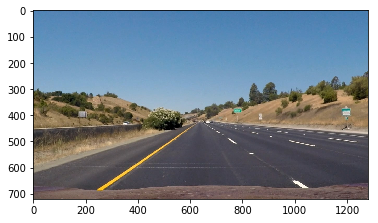

In [19]:
image = cv2.imread("test_images\\straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("shape of image object = ", image.shape)
print("type of image object = ", type(image))
showImg(image)   

## Validate pipeline on test images

Use test images to validate the pipeline.


Chess board shape =  (1280, 720)
Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


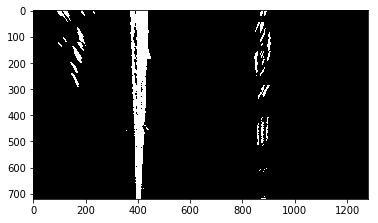

(1280,)
Baseline mid, left, center =  640 400 878
Baeline Lane width in pixels =  478
Inside reset


C:\Users\ADMIN\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


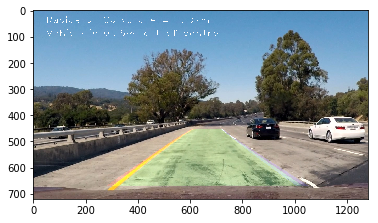

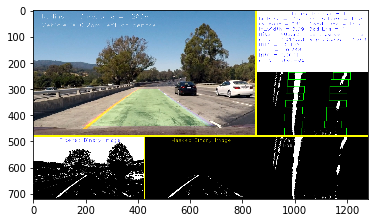

Pair of lines detected =  1


In [81]:
reset_lanes = True
detected_lines = []
# use n for normal, c for challenge and h for harder
terrain_type = 'n'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

images = glob.glob('test_images/test1*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    marked_img = lane_marker_pipeline(image)
    showImg(marked_img)
    combined_imgs = img_collage(marked_img)
    showImg(combined_imgs)
    combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
    cv2.imwrite('text_test.jpg',combined_imgs)
    
print("Pair of lanes detected = ", len(detected_lines))
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!



In [83]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [84]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Calling pipeline that will return the final output (image where lines are drawn on lanes)
        
    result = lane_marker_pipeline(image)
    result = img_collage(result)

    return result

Let's try the one with the solid white lane on the right first ...

Chess board shape =  (1280, 720)
Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


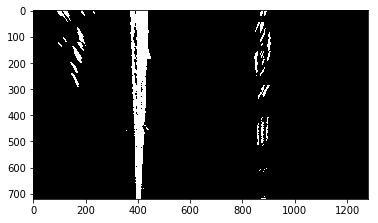

(1280,)
Baseline mid, left, center =  640 400 878
Baeline Lane width in pixels =  478
Inside reset
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  1%|█▎                                                                                                                                                                                                    | 8/1261 [00:02<07:25,  2.81it/s]

@ 9  > Continuity check failed - right curve variation high :  1346.48871816 5984.90810247


  1%|█▍                                                                                                                                                                                                    | 9/1261 [00:03<07:48,  2.68it/s]

@ 10  > Continuity check failed - right curve variation high :  580.616242498 5984.90810247


  1%|█▌                                                                                                                                                                                                   | 10/1261 [00:03<07:58,  2.62it/s]

@ 11  > Continuity check failed - right curve variation high :  346.983448037 5984.90810247


  1%|█▋                                                                                                                                                                                                   | 11/1261 [00:04<08:08,  2.56it/s]

@ 12  > Continuity check failed - right curve variation high :  378.229522029 5984.90810247


  1%|█▊                                                                                                                                                                                                   | 12/1261 [00:04<08:14,  2.53it/s]

@ 13  > Continuity check failed - right curve variation high :  369.084478146 5984.90810247


  1%|██                                                                                                                                                                                                   | 13/1261 [00:04<08:24,  2.47it/s]

@ 14  > Continuity check failed - right curve variation high :  498.533573582 5984.90810247


  1%|██▏                                                                                                                                                                                                  | 14/1261 [00:05<08:32,  2.43it/s]

Inside reset


  2%|███▌                                                                                                                                                                                                 | 23/1261 [00:08<07:55,  2.60it/s]

@ 24  > Continuity check failed - right curve variation high :  388.635778207 1674.15762253


  2%|███▋                                                                                                                                                                                                 | 24/1261 [00:09<07:58,  2.59it/s]

@ 25  > Continuity check failed - right curve variation high :  299.684978984 1674.15762253


  2%|███▉                                                                                                                                                                                                 | 25/1261 [00:09<08:05,  2.54it/s]

@ 26  > Continuity check failed - right curve variation high :  341.909165057 1674.15762253


  2%|████                                                                                                                                                                                                 | 26/1261 [00:09<08:11,  2.51it/s]

@ 27  > Continuity check failed - right curve variation high :  380.054717176 1674.15762253


  2%|████▏                                                                                                                                                                                                | 27/1261 [00:10<08:18,  2.48it/s]

@ 28  > Continuity check failed - right curve variation high :  415.337620531 1674.15762253


 24%|███████████████████████████████████████████████▍                                                                                                                                                    | 305/1261 [01:54<05:35,  2.85it/s]

@ 306  > Continuity check failed - right curve variation high :  677.035785138 3044.53535074


 24%|███████████████████████████████████████████████▊                                                                                                                                                    | 308/1261 [01:55<05:40,  2.80it/s]

@ 309  > curve check failure :  3749.69573543 368492.438245


 25%|████████████████████████████████████████████████▍                                                                                                                                                   | 312/1261 [01:57<05:37,  2.81it/s]

@ 313  > Continuity check failed - right curve variation high :  990.799113664 4340.8548897


 25%|████████████████████████████████████████████████▋                                                                                                                                                   | 313/1261 [01:57<05:38,  2.80it/s]

@ 314  > Continuity check failed - right curve variation high :  940.492830648 4340.8548897


 25%|████████████████████████████████████████████████▊                                                                                                                                                   | 314/1261 [01:57<05:35,  2.82it/s]

@ 315  > curve check failure :  47960.7528408 873.398891382


 25%|████████████████████████████████████████████████▉                                                                                                                                                   | 315/1261 [01:58<05:45,  2.74it/s]

@ 316  > curve check failure :  27566.8345319 672.444923485


 25%|█████████████████████████████████████████████████                                                                                                                                                   | 316/1261 [01:58<05:46,  2.73it/s]

@ 317  > curve check failure :  24917.9149235 427.392990724


 25%|█████████████████████████████████████████████████▎                                                                                                                                                  | 317/1261 [01:58<05:45,  2.74it/s]

@ 318  > curve check failure :  21419.0705693 1401.43436979


 25%|█████████████████████████████████████████████████▍                                                                                                                                                  | 318/1261 [01:59<05:44,  2.74it/s]

Inside reset


 25%|█████████████████████████████████████████████████▌                                                                                                                                                  | 319/1261 [01:59<05:41,  2.76it/s]

@ 320  > curve check failure :  10130.9861877 34787.5058077


 25%|█████████████████████████████████████████████████▋                                                                                                                                                  | 320/1261 [02:00<05:45,  2.73it/s]

@ 321  > curve check failure :  8045.31221108 40323.6309541


 26%|██████████████████████████████████████████████████                                                                                                                                                  | 322/1261 [02:00<05:38,  2.77it/s]

@ 323  > curve check failure :  20923.0669001 4099.54136366


 26%|██████████████████████████████████████████████████▏                                                                                                                                                 | 323/1261 [02:01<05:38,  2.77it/s]

@ 324  > curve check failure :  27320.202763 3639.33903585


 26%|██████████████████████████████████████████████████▋                                                                                                                                                 | 326/1261 [02:02<05:32,  2.81it/s]

@ 327  > left and right curves similarity failure :  13684.2360071 1013.10428755


 26%|██████████████████████████████████████████████████▉                                                                                                                                                 | 328/1261 [02:02<05:30,  2.82it/s]

@ 329  > left and right curves similarity failure :  16333.2470613 784.023322416


 26%|███████████████████████████████████████████████████▌                                                                                                                                                | 332/1261 [02:04<05:32,  2.79it/s]

@ 333  > Continuity check failed - right curve variation high :  1258.00045683 13061.1669878


 26%|███████████████████████████████████████████████████▊                                                                                                                                                | 333/1261 [02:04<05:33,  2.79it/s]

@ 334  > left and right curves similarity failure :  12589.382036 1372.24407708


 26%|███████████████████████████████████████████████████▉                                                                                                                                                | 334/1261 [02:05<05:35,  2.77it/s]

@ 335  > Continuity check failed - right curve variation high :  1648.38945322 13061.1669878


 27%|████████████████████████████████████████████████████                                                                                                                                                | 335/1261 [02:05<05:35,  2.76it/s]

@ 336  > left and right curves similarity failure :  17682.857589 1783.98973274


 27%|████████████████████████████████████████████████████▏                                                                                                                                               | 336/1261 [02:05<05:32,  2.79it/s]

@ 337  > Continuity check failed - right curve variation high :  1644.30911531 13061.1669878


 27%|████████████████████████████████████████████████████▍                                                                                                                                               | 337/1261 [02:06<05:36,  2.74it/s]

@ 338  > Continuity check failed - right curve variation high :  2438.13293138 13061.1669878


 27%|████████████████████████████████████████████████████▌                                                                                                                                               | 338/1261 [02:06<05:37,  2.74it/s]

Inside reset


 27%|█████████████████████████████████████████████████████                                                                                                                                               | 341/1261 [02:07<05:28,  2.80it/s]

@ 342  > left and right curves similarity failure :  17278.6232978 3320.94314002


 27%|█████████████████████████████████████████████████████▏                                                                                                                                              | 342/1261 [02:07<05:34,  2.75it/s]

@ 343  > curve check failure :  22703.5812562 2579.04943832


 27%|█████████████████████████████████████████████████████▎                                                                                                                                              | 343/1261 [02:08<05:33,  2.75it/s]

@ 344  > curve check failure :  33117.3742251 11454.321144


 27%|█████████████████████████████████████████████████████▍                                                                                                                                              | 344/1261 [02:08<05:32,  2.76it/s]

@ 345  > curve check failure :  30234.3509036 15886.076037


 27%|█████████████████████████████████████████████████████▌                                                                                                                                              | 345/1261 [02:09<05:28,  2.79it/s]

@ 346  > curve check failure :  25340.3086363 67121.4674292


 28%|███████████████████████████████████████████████████████▎                                                                                                                                            | 356/1261 [02:12<05:25,  2.78it/s]

@ 357  > left and right curves similarity failure :  15376.2625571 3789.88033511


 28%|███████████████████████████████████████████████████████▍                                                                                                                                            | 357/1261 [02:13<05:24,  2.79it/s]

@ 358  > curve check failure :  34940.0927603 13671.8515791


 29%|███████████████████████████████████████████████████████▉                                                                                                                                            | 360/1261 [02:14<05:19,  2.82it/s]

@ 361  > curve check failure :  2237.96127555 455579.784106


 29%|████████████████████████████████████████████████████████                                                                                                                                            | 361/1261 [02:14<05:21,  2.80it/s]

@ 362  > Continuity check failed - right curve variation high :  1670.53255529 6771.65495255


 29%|████████████████████████████████████████████████████████▎                                                                                                                                           | 362/1261 [02:15<05:24,  2.77it/s]

@ 363  > Continuity check failed - right curve variation high :  1238.02570108 6771.65495255


 29%|████████████████████████████████████████████████████████▍                                                                                                                                           | 363/1261 [02:15<05:25,  2.76it/s]

@ 364  > Continuity check failed - right curve variation high :  976.652017815 6771.65495255


 29%|████████████████████████████████████████████████████████▌                                                                                                                                           | 364/1261 [02:15<05:29,  2.73it/s]

@ 365  > Continuity check failed - right curve variation high :  784.699420371 6771.65495255


 29%|████████████████████████████████████████████████████████▋                                                                                                                                           | 365/1261 [02:16<05:33,  2.69it/s]

@ 366  > Continuity check failed - right curve variation high :  980.084522909 6771.65495255


 29%|████████████████████████████████████████████████████████▉                                                                                                                                           | 366/1261 [02:16<05:29,  2.71it/s]

Inside reset


 30%|██████████████████████████████████████████████████████████▎                                                                                                                                         | 375/1261 [02:19<05:08,  2.87it/s]

@ 376  > left and right curves similarity failure :  11321.3072881 1030.02908703


 30%|██████████████████████████████████████████████████████████▍                                                                                                                                         | 376/1261 [02:20<05:13,  2.82it/s]

@ 377  > left and right curves similarity failure :  13402.1155443 833.209294545


 32%|██████████████████████████████████████████████████████████████▏                                                                                                                                     | 400/1261 [02:28<05:02,  2.85it/s]

@ 401  > curve check failure :  22883.9848437 1438.24802997


 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                     | 401/1261 [02:28<05:04,  2.82it/s]

@ 402  > curve check failure :  105248.72579 7154.68908745


 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                    | 409/1261 [02:31<04:57,  2.86it/s]

@ 410  > left and right curves similarity failure :  19646.8433011 1644.04172669


 33%|███████████████████████████████████████████████████████████████▋                                                                                                                                    | 410/1261 [02:32<05:02,  2.81it/s]

@ 411  > left and right curves similarity failure :  18695.3317123 1232.52380284


 33%|███████████████████████████████████████████████████████████████▉                                                                                                                                    | 411/1261 [02:32<05:05,  2.79it/s]

@ 412  > curve check failure :  181628.213181 1190.08320229


 33%|████████████████████████████████████████████████████████████████                                                                                                                                    | 412/1261 [02:32<05:05,  2.78it/s]

@ 413  > left and right curves similarity failure :  16021.7274535 2914.22668524


 33%|████████████████████████████████████████████████████████████████▏                                                                                                                                   | 413/1261 [02:33<05:04,  2.79it/s]

@ 414  > Continuity check failed - right curve variation high :  1979.3724604 9018.32339974


 33%|████████████████████████████████████████████████████████████████▎                                                                                                                                   | 414/1261 [02:33<05:03,  2.79it/s]

@ 415  > Continuity check failed - right curve variation high :  1767.99423349 9018.32339974


 33%|████████████████████████████████████████████████████████████████▌                                                                                                                                   | 415/1261 [02:33<05:03,  2.79it/s]

Inside reset


 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                 | 429/1261 [02:38<04:52,  2.85it/s]

@ 430  > curve check failure :  123480.184311 1352.04904064


 34%|██████████████████████████████████████████████████████████████████▊                                                                                                                                 | 430/1261 [02:39<04:52,  2.85it/s]

@ 431  > left and right curves similarity failure :  15241.8950926 1721.52011823


 35%|███████████████████████████████████████████████████████████████████▊                                                                                                                                | 436/1261 [02:41<04:53,  2.81it/s]

@ 437  > left and right curves similarity failure :  3624.60947246 15798.3045511


 35%|████████████████████████████████████████████████████████████████████                                                                                                                                | 438/1261 [02:42<04:51,  2.83it/s]

@ 439  > Continuity check failed - right curve variation high :  789.999524672 4113.26657851


 35%|████████████████████████████████████████████████████████████████████▊                                                                                                                               | 443/1261 [02:43<04:49,  2.82it/s]

@ 444  > curve check failure :  2515.80814876 31914.2173422


 35%|█████████████████████████████████████████████████████████████████████                                                                                                                               | 444/1261 [02:44<04:52,  2.79it/s]

@ 445  > curve check failure :  2732.96930919 24849.7588715


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                              | 446/1261 [02:45<04:51,  2.79it/s]

@ 447  > curve check failure :  3477.54003116 102750.488408


 36%|█████████████████████████████████████████████████████████████████████▋                                                                                                                              | 448/1261 [02:45<04:51,  2.79it/s]

@ 449  > Continuity check failed - right curve variation high :  896.192788141 8375.89816388


 36%|█████████████████████████████████████████████████████████████████████▊                                                                                                                              | 449/1261 [02:46<04:57,  2.73it/s]

@ 450  > Continuity check failed - right curve variation high :  743.612593532 8375.89816388


 36%|█████████████████████████████████████████████████████████████████████▉                                                                                                                              | 450/1261 [02:46<04:56,  2.74it/s]

@ 451  > Continuity check failed - right curve variation high :  643.296698569 8375.89816388


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                              | 451/1261 [02:46<04:56,  2.73it/s]

@ 452  > Continuity check failed - right curve variation high :  796.137473488 8375.89816388


 36%|██████████████████████████████████████████████████████████████████████▎                                                                                                                             | 452/1261 [02:47<04:57,  2.72it/s]

@ 453  > Continuity check failed - right curve variation high :  1617.25791516 8375.89816388


 36%|██████████████████████████████████████████████████████████████████████▌                                                                                                                             | 454/1261 [02:47<04:52,  2.76it/s]

@ 455  > left and right curves similarity failure :  18039.8392473 1961.30387864


 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                             | 455/1261 [02:48<04:52,  2.76it/s]

@ 456  > Continuity check failed - right curve variation high :  1433.65311536 8435.61627671


 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                            | 462/1261 [02:50<04:41,  2.84it/s]

@ 463  > curve check failure :  1878.73685422 34305.8714893


 37%|████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 465/1261 [02:51<04:39,  2.85it/s]

@ 466  > Continuity check failed - right curve variation high :  2378.98171982 9536.87753096


 37%|████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 466/1261 [02:52<04:43,  2.81it/s]

@ 467  > Continuity check failed - right curve variation high :  1188.17410717 9536.87753096


 37%|████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 467/1261 [02:52<04:44,  2.79it/s]

@ 468  > Continuity check failed - right curve variation high :  1103.11139978 9536.87753096


 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 468/1261 [02:52<04:44,  2.79it/s]

@ 469  > Continuity check failed - right curve variation high :  984.817405916 9536.87753096


 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 469/1261 [02:53<04:43,  2.80it/s]

@ 470  > Continuity check failed - right curve variation high :  984.61922253 9536.87753096


 37%|█████████████████████████████████████████████████████████████████████████                                                                                                                           | 470/1261 [02:53<04:45,  2.77it/s]

@ 471  > Continuity check failed - right curve variation high :  2049.3669693 9536.87753096


 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 471/1261 [02:54<04:46,  2.76it/s]

Inside reset


 38%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 473/1261 [02:54<04:44,  2.77it/s]

@ 474  > left and right curves similarity failure :  16215.6774448 1362.87239143


 38%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 474/1261 [02:55<04:44,  2.76it/s]

@ 475  > curve check failure :  42365.7882647 2075.79650752


 38%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 480/1261 [02:57<04:37,  2.81it/s]

@ 481  > left and right curves similarity failure :  3664.54232648 15198.9839203


 38%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 484/1261 [02:58<04:34,  2.83it/s]

@ 485  > curve check failure :  9055.54851402 23649.6650031


 39%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 486/1261 [02:59<04:34,  2.82it/s]

@ 487  > curve check failure :  33192.8944179 1969.10667684


 39%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 487/1261 [02:59<04:37,  2.79it/s]

@ 488  > curve check failure :  88739.0877746 897.863509116


 39%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 488/1261 [03:00<04:39,  2.77it/s]

@ 489  > left and right curves similarity failure :  12634.449089 1326.46222376


 39%|████████████████████████████████████████████████████████████████████████████                                                                                                                        | 489/1261 [03:00<04:37,  2.78it/s]

@ 490  > curve check failure :  27658.9036751 2213.97419935


 39%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 490/1261 [03:00<04:40,  2.75it/s]

@ 491  > curve check failure :  42265.4443026 5203.4761029


 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 491/1261 [03:01<04:37,  2.78it/s]

@ 492  > curve check failure :  16070.6445879 34214.8075895


 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 492/1261 [03:01<04:42,  2.72it/s]

Inside reset
@ 493  > left and right curves similarity failure :  17069.2367223 2608.7326274


 39%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 493/1261 [03:01<04:46,  2.68it/s]

Inside reset
@ 494  > curve check failure :  27281.3452084 2881.22972929


 39%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 494/1261 [03:02<04:48,  2.66it/s]

Inside reset
@ 495  > curve check failure :  23789.7537214 1570.67274041


 39%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 495/1261 [03:02<04:48,  2.66it/s]

Inside reset


 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                       | 496/1261 [03:03<04:46,  2.67it/s]

@ 497  > curve check failure :  15253.3602205 25498.9886992


 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 497/1261 [03:03<04:45,  2.68it/s]

@ 498  > curve check failure :  22380.8752898 1634.57148482


 39%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 498/1261 [03:03<04:42,  2.70it/s]

@ 499  > curve check failure :  49265.6786657 2210.73921117


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                      | 502/1261 [03:05<04:32,  2.79it/s]

@ 503  > left and right curves similarity failure :  12662.846191 1286.64955077


 40%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 503/1261 [03:05<04:33,  2.77it/s]

@ 504  > left and right curves similarity failure :  16419.7890278 1039.5637906


 40%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 504/1261 [03:05<04:33,  2.77it/s]

@ 505  > left and right curves similarity failure :  16211.8508195 6081.06001858


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 505/1261 [03:06<04:31,  2.78it/s]

@ 506  > left and right curves similarity failure :  18047.0162515 4037.27773554


 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 506/1261 [03:06<04:37,  2.72it/s]

@ 507  > curve check failure :  30376.043812 1896.76075477


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 507/1261 [03:07<04:38,  2.71it/s]

@ 508  > Continuity check failed - right curve variation high :  815.60441945 4579.65938699


 40%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 508/1261 [03:07<04:37,  2.71it/s]

Inside reset
@ 509  > curve check failure :  141955.114278 470.427616544


 40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                     | 509/1261 [03:07<04:40,  2.68it/s]

Inside reset
@ 510  > curve check failure :  5612.46045834 58460.8323575


 40%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 510/1261 [03:08<04:43,  2.65it/s]

Inside reset


 41%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 512/1261 [03:08<04:36,  2.71it/s]

@ 513  > Continuity check failed - right curve variation high :  903.617802845 10336.1051471


 41%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 513/1261 [03:09<04:36,  2.71it/s]

@ 514  > curve check failure :  22329.3184806 800.71752879


 41%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 514/1261 [03:09<04:35,  2.71it/s]

@ 515  > curve check failure :  175427.864396 1138.29972774


 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 515/1261 [03:10<04:33,  2.72it/s]

@ 516  > Continuity check failed - right curve variation high :  1232.52449937 10336.1051471


 41%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 516/1261 [03:10<04:34,  2.72it/s]

@ 517  > Continuity check failed - right curve variation high :  1649.34745646 10336.1051471


 41%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 519/1261 [03:11<04:29,  2.75it/s]

@ 520  > left and right curves similarity failure :  14954.5432449 1073.8175038


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 520/1261 [03:11<04:28,  2.76it/s]

@ 521  > Continuity check failed - right curve variation high :  724.448176409 3515.28098478


 42%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 526/1261 [03:14<04:26,  2.75it/s]

@ 527  > curve check failure :  257469.662117 663.787618375


 42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 534/1261 [03:16<04:18,  2.81it/s]

@ 535  > lane width failure :  4.21262713684


 42%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 535/1261 [03:17<04:31,  2.67it/s]

@ 536  > lane width failure :  4.21262713684


 43%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 536/1261 [03:17<04:30,  2.68it/s]

@ 537  > lane width failure :  4.21262713684


 43%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 537/1261 [03:18<04:31,  2.66it/s]

@ 538  > lane width failure :  4.21262713684


 43%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 538/1261 [03:18<04:31,  2.67it/s]

@ 539  > lane width failure :  4.21262713684


 43%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 539/1261 [03:18<04:31,  2.66it/s]

@ 540  > lane width failure :  4.21262713684


 43%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 540/1261 [03:19<04:36,  2.60it/s]

Inside reset


 43%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 542/1261 [03:20<04:45,  2.52it/s]

@ 543  > 1st order coefficient similarity failure :  0.0281436566843 -0.343866880709


 44%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 554/1261 [03:24<04:11,  2.81it/s]

@ 555  > Continuity check failed - right curve variation high :  402.419604546 2650.607648


 44%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 555/1261 [03:24<04:12,  2.80it/s]

@ 556  > Continuity check failed - right curve variation high :  417.868530813 2650.607648


 44%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 556/1261 [03:25<04:14,  2.77it/s]

@ 557  > left and right curves similarity failure :  13691.3856236 1308.57102316


 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 562/1261 [03:27<04:06,  2.83it/s]

@ 563  > curve check failure :  29591.296141 896.138754017


 45%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 563/1261 [03:27<04:07,  2.82it/s]

@ 564  > Continuity check failed - left curve variation high :  804.563798321 9203.28892437


 45%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 564/1261 [03:28<04:09,  2.79it/s]

@ 565  > left and right curves similarity failure :  215.515576757 17519.302334


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 565/1261 [03:28<04:11,  2.76it/s]

@ 566  > 2nd order coefficient similarity failure :  -0.00082209274386 -1.27992014819e-05


 45%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 566/1261 [03:28<04:12,  2.76it/s]

@ 567  > 2nd order coefficient similarity failure :  -0.000876675999339 -2.39676806578e-05


 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 567/1261 [03:29<04:08,  2.79it/s]

@ 568  > 2nd order coefficient similarity failure :  -0.000823202170215 0.000190807380121


 45%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 568/1261 [03:29<04:17,  2.70it/s]

Inside reset


 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 570/1261 [03:30<04:16,  2.69it/s]

@ 571  > curve check failure :  62561.9439021 535.180763581


 45%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 572/1261 [03:31<04:20,  2.64it/s]

@ 573  > curve check failure :  176629.215023 803.037957589


 46%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 579/1261 [03:33<04:13,  2.69it/s]

@ 580  > Continuity check failed - left curve variation high :  937.798036096 5025.76689983


 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 580/1261 [03:34<04:24,  2.57it/s]

@ 581  > left and right curves similarity failure :  2899.53919825 16877.8716761


 46%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 581/1261 [03:34<04:23,  2.58it/s]

@ 582  > left and right curves similarity failure :  15028.0023231 1739.71970553


 46%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 582/1261 [03:34<04:21,  2.60it/s]

@ 583  > curve check failure :  412551.801247 833.811091388


 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 583/1261 [03:35<04:25,  2.56it/s]

@ 584  > Continuity check failed - left curve variation high :  805.940345523 5025.76689983


 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 584/1261 [03:35<04:21,  2.59it/s]

@ 585  > Continuity check failed - left curve variation high :  961.817163267 5025.76689983


 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 585/1261 [03:35<04:18,  2.61it/s]

Inside reset


 47%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 588/1261 [03:37<04:05,  2.74it/s]

@ 589  > 1st order coefficient similarity failure :  0.227468449383 -0.124839818214


 47%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 593/1261 [03:38<03:57,  2.81it/s]

@ 594  > curve check failure :  736.117369584 20407.6714225


 47%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 595/1261 [03:39<04:04,  2.72it/s]

@ 596  > curve check failure :  581.016623779 165107.192049


 48%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 599/1261 [03:41<04:01,  2.74it/s]

@ 600  > Continuity check failed - right curve variation high :  741.509835384 3745.97463351


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 600/1261 [03:41<04:04,  2.70it/s]

@ 601  > Continuity check failed - right curve variation high :  640.957839152 3745.97463351


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 601/1261 [03:41<04:06,  2.68it/s]

@ 602  > Continuity check failed - right curve variation high :  627.459928042 3745.97463351


 49%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 618/1261 [03:47<03:50,  2.79it/s]

@ 619  > Continuity check failed - right curve variation high :  812.243138374 7979.68524754


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 619/1261 [03:48<03:52,  2.76it/s]

@ 620  > Continuity check failed - right curve variation high :  873.856100506 7979.68524754


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 620/1261 [03:48<03:53,  2.74it/s]

@ 621  > Continuity check failed - right curve variation high :  552.490078442 7979.68524754


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 621/1261 [03:49<04:00,  2.66it/s]

@ 622  > Continuity check failed - right curve variation high :  775.99107203 7979.68524754


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 622/1261 [03:49<03:57,  2.69it/s]

@ 623  > Continuity check failed - right curve variation high :  648.267776076 7979.68524754


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 623/1261 [03:49<03:57,  2.69it/s]

@ 624  > Continuity check failed - right curve variation high :  667.144006332 7979.68524754


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 624/1261 [03:50<03:57,  2.68it/s]

Inside reset


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 694/1261 [04:14<03:20,  2.83it/s]

@ 695  > Continuity check failed - right curve variation high :  1082.12588532 5640.10276433


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 695/1261 [04:15<03:22,  2.80it/s]

@ 696  > Continuity check failed - right curve variation high :  697.755218943 5640.10276433


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 696/1261 [04:15<03:22,  2.79it/s]

@ 697  > Continuity check failed - right curve variation high :  527.277195075 5640.10276433


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 697/1261 [04:16<03:21,  2.80it/s]

@ 698  > Continuity check failed - right curve variation high :  511.249170256 5640.10276433


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 698/1261 [04:16<03:26,  2.73it/s]

@ 699  > Continuity check failed - right curve variation high :  605.283008898 5640.10276433


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 699/1261 [04:16<03:25,  2.73it/s]

@ 700  > Continuity check failed - right curve variation high :  702.903009024 5640.10276433


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 700/1261 [04:17<03:26,  2.71it/s]

Inside reset


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 799/1261 [04:54<02:56,  2.61it/s]

@ 800  > left and right curves similarity failure :  1422.20280555 17045.8562357


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 922/1261 [05:44<02:12,  2.55it/s]

@ 923  > curve check failure :  725.508087338 28103.6407117


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 959/1261 [05:59<02:06,  2.39it/s]

@ 960  > Continuity check failed - right curve variation high :  1039.15258537 5438.09009807


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 960/1261 [06:00<02:09,  2.33it/s]

@ 961  > Continuity check failed - right curve variation high :  958.435180909 5438.09009807


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 961/1261 [06:00<02:09,  2.32it/s]

@ 962  > Continuity check failed - right curve variation high :  820.945763339 5438.09009807


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 962/1261 [06:00<02:05,  2.39it/s]

@ 963  > Continuity check failed - right curve variation high :  613.298174691 5438.09009807


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 963/1261 [06:01<02:02,  2.44it/s]

@ 964  > Continuity check failed - right curve variation high :  513.509502196 5438.09009807


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 964/1261 [06:01<02:03,  2.41it/s]

@ 965  > Continuity check failed - right curve variation high :  1086.16240149 5438.09009807


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 965/1261 [06:02<02:03,  2.40it/s]

Inside reset


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 973/1261 [06:05<02:03,  2.34it/s]

@ 974  > left and right curves similarity failure :  1667.46847245 13267.018419


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 975/1261 [06:06<01:58,  2.42it/s]

@ 976  > 2nd order coefficient similarity failure :  2.51572541856e-05 -0.000520454003988


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 976/1261 [06:07<01:58,  2.41it/s]

@ 977  > 2nd order coefficient similarity failure :  6.56528811882e-05 -0.000643878762785


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 977/1261 [06:07<01:59,  2.38it/s]

@ 978  > 2nd order coefficient similarity failure :  7.14889106446e-05 -0.000435957512029


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 979/1261 [06:08<01:58,  2.38it/s]

@ 980  > 2nd order coefficient similarity failure :  3.8031415988e-05 -0.000570381401701


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 980/1261 [06:08<01:55,  2.43it/s]

@ 981  > 2nd order coefficient similarity failure :  1.86680657409e-05 -0.000578762865956


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 982/1261 [06:09<01:52,  2.48it/s]

@ 983  > Continuity check failed - left curve variation high :  1626.30171378 6999.862079


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 993/1261 [06:15<02:14,  1.99it/s]

@ 994  > 1st order coefficient similarity failure :  -0.158483080602 -0.570748638754


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1001/1261 [06:18<01:49,  2.37it/s]

@ 1002  > curve check failure :  3215.25000229 54890.0972435


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1002/1261 [06:19<01:51,  2.32it/s]

@ 1003  > left and right curves similarity failure :  16243.6074145 5684.34585359


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1003/1261 [06:19<01:50,  2.33it/s]

@ 1004  > left and right curves similarity failure :  12382.1376943 794.131965832


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1004/1261 [06:20<01:49,  2.35it/s]

@ 1005  > 1st order coefficient similarity failure :  -0.0153165087884 -0.385784666308


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1005/1261 [06:20<01:49,  2.34it/s]

@ 1006  > 1st order coefficient similarity failure :  0.0222070206124 -0.422485962388


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1006/1261 [06:20<01:48,  2.35it/s]

@ 1007  > 2nd order coefficient similarity failure :  -9.65925084947e-05 0.000419152765048


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1007/1261 [06:21<01:49,  2.31it/s]

Inside reset


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1053/1261 [06:40<01:36,  2.16it/s]

@ 1054  > curve check failure :  1056.7099256 172365.669145


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1099/1261 [07:00<01:14,  2.17it/s]

@ 1100  > left and right curves similarity failure :  2184.07219486 16091.8697997


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1229/1261 [07:55<00:12,  2.56it/s]

@ 1230  > Continuity check failed - right curve variation high :  593.772091549 3173.1236965


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1230/1261 [07:56<00:12,  2.52it/s]

@ 1231  > Continuity check failed - right curve variation high :  460.879850088 3173.1236965


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1238/1261 [07:59<00:08,  2.56it/s]

@ 1239  > left and right curves similarity failure :  15998.1602116 1470.03191152


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1240/1261 [08:00<00:08,  2.52it/s]

@ 1241  > Continuity check failed - right curve variation high :  494.833695175 2079.8377573


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1241/1261 [08:00<00:08,  2.46it/s]

@ 1242  > 2nd order coefficient similarity failure :  3.15319015411e-05 -0.000520841528696


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1242/1261 [08:00<00:07,  2.41it/s]

@ 1243  > Continuity check failed - right curve variation high :  281.071137531 2079.8377573


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1243/1261 [08:01<00:07,  2.34it/s]

@ 1244  > Continuity check failed - right curve variation high :  255.190990435 2079.8377573


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1244/1261 [08:01<00:07,  2.27it/s]

@ 1245  > Continuity check failed - right curve variation high :  390.791049383 2079.8377573


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1245/1261 [08:02<00:06,  2.29it/s]

@ 1246  > Continuity check failed - right curve variation high :  257.271767821 2079.8377573


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1246/1261 [08:02<00:06,  2.29it/s]

Inside reset


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1248/1261 [08:03<00:05,  2.37it/s]

@ 1249  > 2nd order coefficient similarity failure :  1.96297176746e-05 -0.000519448848919


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1249/1261 [08:03<00:04,  2.40it/s]

@ 1250  > 2nd order coefficient similarity failure :  1.36882798659e-05 -0.000698890055824


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1250/1261 [08:04<00:04,  2.36it/s]

@ 1251  > 2nd order coefficient similarity failure :  1.39102701027e-05 -0.000852459830327


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1251/1261 [08:04<00:04,  2.38it/s]

@ 1252  > 2nd order coefficient similarity failure :  1.83314066565e-05 -0.000783559976121


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1252/1261 [08:05<00:03,  2.40it/s]

@ 1253  > left and right curves similarity failure :  12970.7772029 127.393287675


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1253/1261 [08:05<00:03,  2.39it/s]

@ 1254  > 2nd order coefficient similarity failure :  1.81149926807e-05 -0.000697962540579


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1254/1261 [08:06<00:02,  2.40it/s]

Inside reset


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1255/1261 [08:06<00:02,  2.33it/s]

@ 1256  > curve check failure :  42947.2902108 228.674364403


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1256/1261 [08:06<00:02,  2.34it/s]

@ 1257  > curve check failure :  151811.175098 209.592930438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1257/1261 [08:07<00:01,  2.35it/s]

@ 1258  > left and right curves similarity failure :  15207.0229175 181.316788637


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1258/1261 [08:07<00:01,  2.36it/s]

@ 1259  > curve check failure :  49370.2183546 211.567147374


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1259/1261 [08:08<00:00,  2.35it/s]

@ 1260  > left and right curves similarity failure :  13935.8758017 195.136239067


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [08:08<00:00,  2.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 8min 10s
Number of frames =  1261


In [85]:
# Initialize variables
reset_lanes = True
detected_lines = []

# use n for normal, c for challenge and h for harder
terrain_type = 'n'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

project_video_output = 'project_video_output.mp4'
#clip1 = VideoFileClip("P2.mp4")
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)
print("Number of frames = ", len(detected_lines))

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

## Challenge Video

Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.

Now for the one with the solid yellow lane on the left. This one's more tricky!

Chess board shape =  (1280, 720)
Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


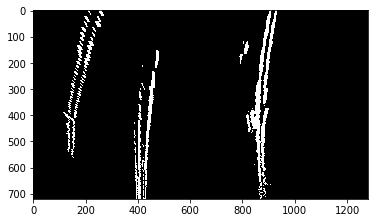

(1280,)
Baseline mid, left, center =  640 406 864
Baeline Lane width in pixels =  458
Inside reset
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


  5%|██████████▏                                                                                                                                                                                           | 25/485 [00:09<02:57,  2.60it/s]

@ 26  > Continuity check failed - right curve variation high :  732.860914046 4181.14177449


  5%|██████████▌                                                                                                                                                                                           | 26/485 [00:09<03:01,  2.53it/s]

@ 27  > Continuity check failed - right curve variation high :  559.1169204 4181.14177449


  6%|███████████                                                                                                                                                                                           | 27/485 [00:10<03:12,  2.38it/s]

@ 28  > Continuity check failed - right curve variation high :  467.419425948 4181.14177449


  6%|███████████▍                                                                                                                                                                                          | 28/485 [00:10<03:09,  2.41it/s]

@ 29  > Continuity check failed - right curve variation high :  431.649242034 4181.14177449


  6%|███████████▊                                                                                                                                                                                          | 29/485 [00:11<03:09,  2.41it/s]

@ 30  > Continuity check failed - right curve variation high :  389.161319195 4181.14177449


  6%|████████████▏                                                                                                                                                                                         | 30/485 [00:11<03:06,  2.44it/s]

@ 31  > Continuity check failed - right curve variation high :  331.681334296 4181.14177449


  6%|████████████▋                                                                                                                                                                                         | 31/485 [00:11<03:04,  2.46it/s]

Inside reset


  7%|██████████████▎                                                                                                                                                                                       | 35/485 [00:13<03:00,  2.49it/s]

@ 36  > lane width failure :  4.22212159316


  7%|██████████████▋                                                                                                                                                                                       | 36/485 [00:14<03:01,  2.48it/s]

@ 37  > lane width failure :  4.22212159316


  8%|███████████████                                                                                                                                                                                       | 37/485 [00:14<03:07,  2.39it/s]

@ 38  > lane width failure :  4.22212159316


  8%|███████████████▌                                                                                                                                                                                      | 38/485 [00:14<03:01,  2.46it/s]

@ 39  > lane width failure :  4.22212159316


  8%|███████████████▉                                                                                                                                                                                      | 39/485 [00:15<02:58,  2.50it/s]

@ 40  > lane width failure :  4.22212159316


  8%|████████████████▎                                                                                                                                                                                     | 40/485 [00:15<02:59,  2.48it/s]

@ 41  > lane width failure :  4.22212159316


  8%|████████████████▋                                                                                                                                                                                     | 41/485 [00:16<03:04,  2.41it/s]

Inside reset


  9%|█████████████████▏                                                                                                                                                                                    | 42/485 [00:16<03:03,  2.41it/s]

@ 43  > Continuity check failed - lane offset variation high :  0.03 -0.54


  9%|█████████████████▌                                                                                                                                                                                    | 43/485 [00:16<03:00,  2.44it/s]

@ 44  > Continuity check failed - lane offset variation high :  0.03 -0.54


  9%|█████████████████▉                                                                                                                                                                                    | 44/485 [00:17<03:00,  2.45it/s]

@ 45  > Continuity check failed - lane offset variation high :  0.03 -0.54


  9%|██████████████████▎                                                                                                                                                                                   | 45/485 [00:17<02:58,  2.47it/s]

@ 46  > Continuity check failed - lane offset variation high :  0.03 -0.54


  9%|██████████████████▊                                                                                                                                                                                   | 46/485 [00:18<02:59,  2.45it/s]

@ 47  > Continuity check failed - lane offset variation high :  0.03 -0.54


 10%|███████████████████▏                                                                                                                                                                                  | 47/485 [00:18<02:58,  2.46it/s]

@ 48  > left and right curves similarity failure :  16506.743164 645.271210778


 10%|███████████████████▌                                                                                                                                                                                  | 48/485 [00:18<02:56,  2.47it/s]

Inside reset


 10%|████████████████████                                                                                                                                                                                  | 49/485 [00:19<02:56,  2.47it/s]

@ 50  > lane width failure :  4.51201413628


 10%|████████████████████▍                                                                                                                                                                                 | 50/485 [00:19<02:56,  2.47it/s]

@ 51  > lane width failure :  4.51201413628


 11%|████████████████████▊                                                                                                                                                                                 | 51/485 [00:20<02:59,  2.42it/s]

@ 52  > lane width failure :  4.51201413628


 11%|█████████████████████▏                                                                                                                                                                                | 52/485 [00:20<02:56,  2.45it/s]

@ 53  > lane width failure :  4.51201413628


 11%|█████████████████████▋                                                                                                                                                                                | 53/485 [00:20<02:55,  2.46it/s]

@ 54  > lane width failure :  4.51201413628


 11%|██████████████████████                                                                                                                                                                                | 54/485 [00:21<02:54,  2.47it/s]

@ 55  > lane width failure :  4.51201413628


 11%|██████████████████████▍                                                                                                                                                                               | 55/485 [00:21<02:55,  2.45it/s]

Inside reset
@ 56  > lane width failure :  5.16222707424


 12%|██████████████████████▊                                                                                                                                                                               | 56/485 [00:22<03:02,  2.35it/s]

Inside reset
@ 57  > lane width failure :  5.1056768559


 12%|███████████████████████▎                                                                                                                                                                              | 57/485 [00:22<02:58,  2.40it/s]

Inside reset
@ 58  > lane width failure :  5.04912663755


 12%|███████████████████████▋                                                                                                                                                                              | 58/485 [00:23<02:56,  2.42it/s]

Inside reset
@ 59  > lane width failure :  4.92794759825


 12%|████████████████████████                                                                                                                                                                              | 59/485 [00:23<02:55,  2.42it/s]

Inside reset
@ 60  > lane width failure :  4.93602620087


 12%|████████████████████████▍                                                                                                                                                                             | 60/485 [00:23<03:00,  2.36it/s]

Inside reset
@ 61  > lane width failure :  4.94410480349


 13%|████████████████████████▉                                                                                                                                                                             | 61/485 [00:24<03:01,  2.33it/s]

Inside reset
@ 62  > lane width failure :  4.99257641921


 13%|█████████████████████████▎                                                                                                                                                                            | 62/485 [00:24<03:01,  2.33it/s]

Inside reset
@ 63  > lane width failure :  4.97641921397


 13%|█████████████████████████▋                                                                                                                                                                            | 63/485 [00:25<03:00,  2.34it/s]

Inside reset
@ 64  > lane width failure :  4.84716157205


 13%|██████████████████████████▏                                                                                                                                                                           | 64/485 [00:25<02:58,  2.36it/s]

Inside reset
@ 65  > lane width failure :  4.80676855895


 13%|██████████████████████████▌                                                                                                                                                                           | 65/485 [00:26<03:01,  2.31it/s]

Inside reset
@ 66  > lane width failure :  4.88755458515


 14%|██████████████████████████▉                                                                                                                                                                           | 66/485 [00:26<02:58,  2.34it/s]

Inside reset
@ 67  > lane width failure :  4.73406113537


 14%|███████████████████████████▎                                                                                                                                                                          | 67/485 [00:26<02:57,  2.35it/s]

Inside reset
@ 68  > lane width failure :  4.58864628821


 14%|███████████████████████████▊                                                                                                                                                                          | 68/485 [00:27<02:57,  2.34it/s]

Inside reset
@ 69  > lane width failure :  4.48362445415


 14%|████████████████████████████▏                                                                                                                                                                         | 69/485 [00:27<02:58,  2.33it/s]

Inside reset
@ 70  > lane width failure :  4.52401746725


 14%|████████████████████████████▌                                                                                                                                                                         | 70/485 [00:28<02:56,  2.36it/s]

Inside reset
@ 71  > lane width failure :  4.59672489083


 15%|████████████████████████████▉                                                                                                                                                                         | 71/485 [00:28<02:54,  2.37it/s]

Inside reset
@ 72  > lane width failure :  4.64519650655


 15%|█████████████████████████████▍                                                                                                                                                                        | 72/485 [00:29<02:53,  2.37it/s]

Inside reset
@ 73  > lane width failure :  4.62903930131


 15%|█████████████████████████████▊                                                                                                                                                                        | 73/485 [00:29<02:53,  2.38it/s]

Inside reset
@ 74  > lane width failure :  4.62903930131


 15%|██████████████████████████████▏                                                                                                                                                                       | 74/485 [00:29<02:56,  2.33it/s]

Inside reset
@ 75  > lane width failure :  4.59672489083


 15%|██████████████████████████████▌                                                                                                                                                                       | 75/485 [00:30<02:53,  2.36it/s]

Inside reset
@ 76  > lane width failure :  4.59672489083


 16%|███████████████████████████████                                                                                                                                                                       | 76/485 [00:30<02:52,  2.37it/s]

Inside reset
@ 77  > lane width failure :  4.75829694323


 16%|███████████████████████████████▍                                                                                                                                                                      | 77/485 [00:31<02:52,  2.37it/s]

Inside reset
@ 78  > lane width failure :  4.66135371179


 16%|███████████████████████████████▊                                                                                                                                                                      | 78/485 [00:31<02:53,  2.34it/s]

Inside reset
@ 79  > lane width failure :  4.58864628821


 16%|████████████████████████████████▎                                                                                                                                                                     | 79/485 [00:31<02:52,  2.35it/s]

Inside reset
@ 80  > lane width failure :  4.55633187773


 16%|████████████████████████████████▋                                                                                                                                                                     | 80/485 [00:32<02:52,  2.35it/s]

Inside reset
@ 81  > lane width failure :  4.50786026201


 17%|█████████████████████████████████                                                                                                                                                                     | 81/485 [00:32<02:50,  2.37it/s]

Inside reset
@ 82  > lane width failure :  4.58056768559


 17%|█████████████████████████████████▍                                                                                                                                                                    | 82/485 [00:33<02:50,  2.37it/s]

Inside reset
@ 83  > lane width failure :  4.58864628821


 17%|█████████████████████████████████▉                                                                                                                                                                    | 83/485 [00:33<02:53,  2.32it/s]

Inside reset
@ 84  > lane width failure :  4.58864628821


 17%|██████████████████████████████████▎                                                                                                                                                                   | 84/485 [00:34<02:51,  2.34it/s]

Inside reset
@ 85  > lane width failure :  4.55633187773


 18%|██████████████████████████████████▋                                                                                                                                                                   | 85/485 [00:34<02:50,  2.35it/s]

Inside reset
@ 86  > lane width failure :  4.52401746725


 18%|███████████████████████████████████                                                                                                                                                                   | 86/485 [00:34<02:49,  2.35it/s]

Inside reset
@ 87  > lane width failure :  4.35436681223


 18%|███████████████████████████████████▌                                                                                                                                                                  | 87/485 [00:35<02:50,  2.33it/s]

Inside reset
@ 88  > lane width failure :  4.32205240175


 18%|███████████████████████████████████▉                                                                                                                                                                  | 88/485 [00:35<02:49,  2.34it/s]

Inside reset
@ 89  > lane width failure :  4.31397379913


 18%|████████████████████████████████████▎                                                                                                                                                                 | 89/485 [00:36<02:47,  2.36it/s]

Inside reset
@ 90  > lane width failure :  4.62903930131


 19%|████████████████████████████████████▋                                                                                                                                                                 | 90/485 [00:36<02:46,  2.38it/s]

Inside reset
@ 91  > lane width failure :  4.60480349345


 19%|█████████████████████████████████████▏                                                                                                                                                                | 91/485 [00:37<02:46,  2.37it/s]

Inside reset
@ 92  > lane width failure :  4.70982532751


 19%|█████████████████████████████████████▌                                                                                                                                                                | 92/485 [00:37<02:50,  2.31it/s]

Inside reset
@ 93  > lane width failure :  4.55633187773


 19%|█████████████████████████████████████▉                                                                                                                                                                | 93/485 [00:37<02:47,  2.33it/s]

Inside reset
@ 94  > lane width failure :  4.54017467249


 19%|██████████████████████████████████████▍                                                                                                                                                               | 94/485 [00:38<02:47,  2.33it/s]

Inside reset
@ 95  > lane width failure :  4.46746724891


 20%|██████████████████████████████████████▊                                                                                                                                                               | 95/485 [00:38<02:47,  2.33it/s]

Inside reset
@ 96  > lane width failure :  4.41091703057


 20%|███████████████████████████████████████▏                                                                                                                                                              | 96/485 [00:39<02:50,  2.28it/s]

Inside reset
@ 97  > lane width failure :  4.37860262009


 20%|███████████████████████████████████████▌                                                                                                                                                              | 97/485 [00:39<02:46,  2.33it/s]

Inside reset
@ 98  > lane width failure :  4.33013100437


 20%|████████████████████████████████████████                                                                                                                                                              | 98/485 [00:40<02:44,  2.35it/s]

Inside reset
@ 99  > lane width failure :  4.26550218341


 20%|████████████████████████████████████████▍                                                                                                                                                             | 99/485 [00:40<02:42,  2.37it/s]

Inside reset
@ 100  > lane width failure :  4.28973799127


 21%|████████████████████████████████████████▌                                                                                                                                                            | 100/485 [00:40<02:41,  2.39it/s]

Inside reset
@ 101  > lane width failure :  4.37052401747


 21%|█████████████████████████████████████████                                                                                                                                                            | 101/485 [00:41<02:43,  2.35it/s]

Inside reset
@ 102  > 1st order coefficient similarity failure :  -0.0650661710939 -0.623556042713


 21%|█████████████████████████████████████████▍                                                                                                                                                           | 102/485 [00:41<02:42,  2.36it/s]

Inside reset
@ 103  > 1st order coefficient similarity failure :  -0.0635239181829 -0.635260125157


 21%|█████████████████████████████████████████▊                                                                                                                                                           | 103/485 [00:42<02:40,  2.37it/s]

Inside reset
@ 104  > lane width failure :  4.68558951965


 21%|██████████████████████████████████████████▏                                                                                                                                                          | 104/485 [00:42<02:40,  2.37it/s]

Inside reset
@ 105  > 1st order coefficient similarity failure :  0.00518929598608 -0.757262207195


 22%|██████████████████████████████████████████▋                                                                                                                                                          | 105/485 [00:43<02:37,  2.41it/s]

Inside reset
@ 106  > 1st order coefficient similarity failure :  -0.00355157570195 -0.776160924158


 22%|███████████████████████████████████████████                                                                                                                                                          | 106/485 [00:43<02:34,  2.45it/s]

Inside reset


 24%|███████████████████████████████████████████████▉                                                                                                                                                     | 118/485 [00:47<02:07,  2.89it/s]

@ 119  > 1st order coefficient similarity failure :  0.0187890601157 -0.446856428652


 25%|████████████████████████████████████████████████▎                                                                                                                                                    | 119/485 [00:47<02:08,  2.85it/s]

@ 120  > curve check failure :  20173.2220825 478.563491132


 25%|████████████████████████████████████████████████▋                                                                                                                                                    | 120/485 [00:48<02:11,  2.77it/s]

@ 121  > 2nd order coefficient similarity failure :  -7.72644024377e-05 0.00108821236


 25%|█████████████████████████████████████████████████▏                                                                                                                                                   | 121/485 [00:48<02:11,  2.76it/s]

@ 122  > 2nd order coefficient similarity failure :  -7.27818014863e-05 0.00114777755671


 25%|█████████████████████████████████████████████████▌                                                                                                                                                   | 122/485 [00:49<02:11,  2.75it/s]

@ 123  > 2nd order coefficient similarity failure :  -0.000327881800539 0.000530274112719


 25%|█████████████████████████████████████████████████▉                                                                                                                                                   | 123/485 [00:49<02:19,  2.60it/s]

@ 124  > 2nd order coefficient similarity failure :  -0.000300778498214 0.000669779942804


 26%|██████████████████████████████████████████████████▎                                                                                                                                                  | 124/485 [00:49<02:19,  2.59it/s]

Inside reset
@ 125  > 2nd order coefficient similarity failure :  -0.000368895459753 0.00035901132993


 26%|██████████████████████████████████████████████████▊                                                                                                                                                  | 125/485 [00:50<02:20,  2.56it/s]

Inside reset
@ 126  > 1st order coefficient similarity failure :  0.825483282685 0.322039174873


 26%|███████████████████████████████████████████████████▏                                                                                                                                                 | 126/485 [00:50<02:20,  2.56it/s]

Inside reset
@ 127  > 2nd order coefficient similarity failure :  -0.000691678660177 -3.76728074188e-05


 26%|███████████████████████████████████████████████████▌                                                                                                                                                 | 127/485 [00:51<02:18,  2.58it/s]

Inside reset
@ 128  > 2nd order coefficient similarity failure :  -0.00151045082413 -0.000241958728288


 26%|███████████████████████████████████████████████████▉                                                                                                                                                 | 128/485 [00:51<02:17,  2.60it/s]

Inside reset
@ 129  > 2nd order coefficient similarity failure :  -0.00224212453379 -0.000319180984223


 27%|████████████████████████████████████████████████████▍                                                                                                                                                | 129/485 [00:51<02:13,  2.66it/s]

Inside reset
@ 130  > 2nd order coefficient similarity failure :  -0.0115419474347 0.000132001869009


 27%|████████████████████████████████████████████████████▊                                                                                                                                                | 130/485 [00:52<02:17,  2.59it/s]

Inside reset
@ 131  > 2nd order coefficient similarity failure :  0.00877981734371 -0.000681679878082


 27%|█████████████████████████████████████████████████████▏                                                                                                                                               | 131/485 [00:52<02:14,  2.63it/s]

Inside reset
@ 132  > 2nd order coefficient similarity failure :  -0.0969087062614 0.00035543271992


 27%|█████████████████████████████████████████████████████▌                                                                                                                                               | 132/485 [00:52<02:14,  2.62it/s]

Inside reset
@ 133  > lane width failure :  2.35087336245


 27%|██████████████████████████████████████████████████████                                                                                                                                               | 133/485 [00:53<02:14,  2.62it/s]

Inside reset
@ 134  > low pass failure :  12 23


 28%|██████████████████████████████████████████████████████▍                                                                                                                                              | 134/485 [00:53<02:17,  2.56it/s]

Inside reset
@ 135  > low pass failure :  11 1042


 28%|██████████████████████████████████████████████████████▊                                                                                                                                              | 135/485 [00:54<02:14,  2.59it/s]

Inside reset
@ 136  > low pass failure :  10 1787


 28%|███████████████████████████████████████████████████████▏                                                                                                                                             | 136/485 [00:54<02:14,  2.59it/s]

Inside reset
@ 137  > lane width failure :  2.1731441048


 28%|███████████████████████████████████████████████████████▋                                                                                                                                             | 137/485 [00:54<02:11,  2.65it/s]

Inside reset
@ 138  > lane width failure :  2.15698689956


 28%|████████████████████████████████████████████████████████                                                                                                                                             | 138/485 [00:55<02:11,  2.64it/s]

Inside reset
@ 139  > lane width failure :  2.22161572052


 29%|████████████████████████████████████████████████████████▍                                                                                                                                            | 139/485 [00:55<02:11,  2.63it/s]

Inside reset
@ 140  > 2nd order coefficient similarity failure :  -0.00110556986813 0.000322230482265


 29%|████████████████████████████████████████████████████████▊                                                                                                                                            | 140/485 [00:56<02:11,  2.62it/s]

Inside reset


 29%|█████████████████████████████████████████████████████████▎                                                                                                                                           | 141/485 [00:56<02:09,  2.66it/s]

@ 142  > 2nd order coefficient similarity failure :  -0.000178072258688 0.000413717094891


 29%|█████████████████████████████████████████████████████████▋                                                                                                                                           | 142/485 [00:56<02:07,  2.69it/s]

@ 143  > 1st order coefficient similarity failure :  0.100326577359 -0.354033682527


 29%|██████████████████████████████████████████████████████████                                                                                                                                           | 143/485 [00:57<02:07,  2.67it/s]

@ 144  > 1st order coefficient similarity failure :  -0.0112188767112 -0.696449287325


 30%|██████████████████████████████████████████████████████████▍                                                                                                                                          | 144/485 [00:57<02:06,  2.70it/s]

@ 145  > 2nd order coefficient similarity failure :  0.000375199850369 0.00103944409191


 30%|██████████████████████████████████████████████████████████▉                                                                                                                                          | 145/485 [00:57<02:08,  2.64it/s]

@ 146  > 2nd order coefficient similarity failure :  0.000100675743486 0.000646750212065


 30%|███████████████████████████████████████████████████████████▎                                                                                                                                         | 146/485 [00:58<02:11,  2.59it/s]

@ 147  > 1st order coefficient similarity failure :  0.0525878696691 -0.471986591211


 30%|███████████████████████████████████████████████████████████▋                                                                                                                                         | 147/485 [00:58<02:11,  2.56it/s]

Inside reset
@ 148  > lane width failure :  4.91179039301


 31%|████████████████████████████████████████████████████████████                                                                                                                                         | 148/485 [00:59<02:13,  2.52it/s]

Inside reset
@ 149  > lane width failure :  4.87139737991


 31%|████████████████████████████████████████████████████████████▌                                                                                                                                        | 149/485 [00:59<02:11,  2.56it/s]

Inside reset
@ 150  > lane width failure :  4.94410480349


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                        | 150/485 [00:59<02:11,  2.55it/s]

Inside reset
@ 151  > lane width failure :  4.83100436681


 31%|█████████████████████████████████████████████████████████████▎                                                                                                                                       | 151/485 [01:00<02:10,  2.57it/s]

Inside reset
@ 152  > lane width failure :  4.77445414847


 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                       | 152/485 [01:00<02:08,  2.59it/s]

Inside reset
@ 153  > lane width failure :  4.58864628821


 32%|██████████████████████████████████████████████████████████████▏                                                                                                                                      | 153/485 [01:01<02:06,  2.62it/s]

Inside reset
@ 154  > lane width failure :  4.71790393013


 32%|██████████████████████████████████████████████████████████████▌                                                                                                                                      | 154/485 [01:01<02:05,  2.63it/s]

Inside reset
@ 155  > lane width failure :  4.60480349345


 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                      | 155/485 [01:01<02:06,  2.61it/s]

Inside reset
@ 156  > lane width failure :  4.57248908297


 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                     | 156/485 [01:02<02:05,  2.61it/s]

Inside reset
@ 157  > 1st order coefficient similarity failure :  0.140407901345 -0.412806663309


 32%|███████████████████████████████████████████████████████████████▊                                                                                                                                     | 157/485 [01:02<02:06,  2.60it/s]

Inside reset
@ 158  > lane width failure :  4.60480349345


 33%|████████████████████████████████████████████████████████████████▏                                                                                                                                    | 158/485 [01:02<02:05,  2.61it/s]

Inside reset
@ 159  > 1st order coefficient similarity failure :  0.0478425865545 -0.487869666081


 33%|████████████████████████████████████████████████████████████████▌                                                                                                                                    | 159/485 [01:03<02:04,  2.61it/s]

Inside reset
@ 160  > 1st order coefficient similarity failure :  0.0577858677989 -0.516653739664


 33%|████████████████████████████████████████████████████████████████▉                                                                                                                                    | 160/485 [01:03<02:04,  2.60it/s]

Inside reset


 33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                   | 162/485 [01:04<02:00,  2.68it/s]

@ 163  > Continuity check failed - right curve variation high :  675.599783427 6568.91741174


 34%|██████████████████████████████████████████████████████████████████▏                                                                                                                                  | 163/485 [01:04<01:59,  2.70it/s]

@ 164  > 1st order coefficient similarity failure :  0.162440338864 -0.283721494479


 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                  | 164/485 [01:05<01:58,  2.70it/s]

@ 165  > 1st order coefficient similarity failure :  0.147157298206 -0.329221106019


 34%|███████████████████████████████████████████████████████████████████                                                                                                                                  | 165/485 [01:05<01:57,  2.72it/s]

@ 166  > 1st order coefficient similarity failure :  0.164108368678 -0.303485332632


 34%|███████████████████████████████████████████████████████████████████▍                                                                                                                                 | 166/485 [01:05<01:55,  2.76it/s]

@ 167  > 1st order coefficient similarity failure :  0.196399851984 -0.311003738228


 34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                 | 167/485 [01:06<01:57,  2.70it/s]

@ 168  > 1st order coefficient similarity failure :  0.178486123868 -0.350465240255


 35%|████████████████████████████████████████████████████████████████████▏                                                                                                                                | 168/485 [01:06<01:57,  2.71it/s]

Inside reset
@ 169  > 1st order coefficient similarity failure :  0.179489880671 -0.372877120888


 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                                | 169/485 [01:07<01:59,  2.65it/s]

Inside reset
@ 170  > 1st order coefficient similarity failure :  0.168716936386 -0.437503316263


 35%|█████████████████████████████████████████████████████████████████████                                                                                                                                | 170/485 [01:07<02:00,  2.62it/s]

Inside reset
@ 171  > 1st order coefficient similarity failure :  0.15226700744 -0.428502962316


 35%|█████████████████████████████████████████████████████████████████████▍                                                                                                                               | 171/485 [01:07<02:00,  2.61it/s]

Inside reset
@ 172  > 1st order coefficient similarity failure :  0.145965482646 -0.470089419564


 35%|█████████████████████████████████████████████████████████████████████▊                                                                                                                               | 172/485 [01:08<02:00,  2.60it/s]

Inside reset
@ 173  > 1st order coefficient similarity failure :  0.14810171795 -0.502154873337


 36%|██████████████████████████████████████████████████████████████████████▎                                                                                                                              | 173/485 [01:08<01:59,  2.62it/s]

Inside reset


 36%|███████████████████████████████████████████████████████████████████████▍                                                                                                                             | 176/485 [01:09<01:52,  2.74it/s]

@ 177  > 1st order coefficient similarity failure :  0.151872062443 -0.245888652924


 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                             | 177/485 [01:10<01:52,  2.74it/s]

@ 178  > 1st order coefficient similarity failure :  0.177673697754 -0.306743865984


 37%|████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 178/485 [01:10<01:50,  2.77it/s]

@ 179  > 1st order coefficient similarity failure :  0.146473368089 -0.318157128605


 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 179/485 [01:10<01:50,  2.77it/s]

@ 180  > 1st order coefficient similarity failure :  0.156224316898 -0.365367989048


 37%|█████████████████████████████████████████████████████████████████████████                                                                                                                            | 180/485 [01:11<01:51,  2.74it/s]

@ 181  > curve check failure :  69110.3584999 317.056471601


 37%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 181/485 [01:11<01:51,  2.73it/s]

@ 182  > 1st order coefficient similarity failure :  0.161867003716 -0.379710403282


 38%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 182/485 [01:11<01:51,  2.72it/s]

Inside reset
@ 183  > 1st order coefficient similarity failure :  0.115467240963 -0.405109281776


 38%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 183/485 [01:12<01:51,  2.70it/s]

Inside reset
@ 184  > 1st order coefficient similarity failure :  0.191339742664 -0.414527180453


 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 184/485 [01:12<01:51,  2.69it/s]

Inside reset
@ 185  > 1st order coefficient similarity failure :  0.182376405206 -0.415677889008


 38%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 185/485 [01:12<01:53,  2.64it/s]

Inside reset
@ 186  > 1st order coefficient similarity failure :  0.152517450123 -0.455531947754


 38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 186/485 [01:13<01:53,  2.63it/s]

Inside reset
@ 187  > 1st order coefficient similarity failure :  0.114045273733 -0.513749196587


 39%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 187/485 [01:13<01:53,  2.62it/s]

Inside reset


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 193/485 [01:15<01:43,  2.81it/s]

@ 194  > 1st order coefficient similarity failure :  0.0506541294098 -0.381867990476


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 194/485 [01:16<01:43,  2.81it/s]

@ 195  > 1st order coefficient similarity failure :  0.017528605583 -0.39794473713


 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 195/485 [01:16<01:44,  2.78it/s]

@ 196  > 1st order coefficient similarity failure :  0.0161184238692 -0.383044990259


 40%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 196/485 [01:16<01:44,  2.78it/s]

@ 197  > 1st order coefficient similarity failure :  0.0724148624411 -0.344266085565


 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 197/485 [01:17<01:44,  2.75it/s]

@ 198  > 1st order coefficient similarity failure :  0.108420876631 -0.352499561904


 41%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 198/485 [01:17<01:44,  2.75it/s]

@ 199  > 1st order coefficient similarity failure :  0.0884877607978 -0.438379018219


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 199/485 [01:18<01:44,  2.74it/s]

Inside reset


 42%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 202/485 [01:19<01:40,  2.81it/s]

@ 203  > Continuity check failed - right curve variation high :  354.106795979 7549.70861353


 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 203/485 [01:19<01:40,  2.82it/s]

@ 204  > Continuity check failed - right curve variation high :  270.134553109 7549.70861353


 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 204/485 [01:19<01:41,  2.76it/s]

@ 205  > Continuity check failed - right curve variation high :  276.910054904 7549.70861353


 42%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 205/485 [01:20<01:41,  2.76it/s]

@ 206  > Continuity check failed - right curve variation high :  334.741741746 7549.70861353


 42%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 206/485 [01:20<01:41,  2.75it/s]

@ 207  > Continuity check failed - right curve variation high :  242.972940034 7549.70861353


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 207/485 [01:20<01:40,  2.75it/s]

@ 208  > 1st order coefficient similarity failure :  -0.00687620983003 -0.39965472954


 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 208/485 [01:21<01:40,  2.76it/s]

Inside reset
@ 209  > 1st order coefficient similarity failure :  0.0158929141684 -0.378343991533


 43%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 209/485 [01:21<01:42,  2.69it/s]

Inside reset
@ 210  > 1st order coefficient similarity failure :  0.0199965119386 -0.453887867597


 43%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 210/485 [01:22<01:42,  2.68it/s]

Inside reset
@ 211  > 1st order coefficient similarity failure :  0.03491856259 -0.410412648646


 44%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 211/485 [01:22<01:44,  2.61it/s]

Inside reset


 45%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 220/485 [01:25<01:34,  2.82it/s]

@ 221  > 1st order coefficient similarity failure :  -0.0276159051461 -0.410413968037


 46%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 221/485 [01:26<01:34,  2.78it/s]

@ 222  > 1st order coefficient similarity failure :  0.000298743825533 -0.386453997768


 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 222/485 [01:26<01:34,  2.78it/s]

@ 223  > 1st order coefficient similarity failure :  0.00650149547871 -0.427764271456


 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 223/485 [01:26<01:35,  2.75it/s]

@ 224  > 1st order coefficient similarity failure :  -0.0219835472679 -0.420875539277


 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 224/485 [01:27<01:35,  2.73it/s]

@ 225  > 1st order coefficient similarity failure :  -0.0543740061245 -0.509308848085


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 246/485 [01:34<01:24,  2.84it/s]

@ 247  > 1st order coefficient similarity failure :  0.0208796355319 -0.329635058056


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 247/485 [01:35<01:25,  2.77it/s]

@ 248  > 1st order coefficient similarity failure :  7.10261403771e-05 -0.39640043468


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 248/485 [01:35<01:25,  2.79it/s]

@ 249  > 1st order coefficient similarity failure :  0.0280245738163 -0.351765641408


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 249/485 [01:35<01:27,  2.69it/s]

@ 250  > 1st order coefficient similarity failure :  0.014476243788 -0.370178831845


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 250/485 [01:36<01:27,  2.67it/s]

@ 251  > 1st order coefficient similarity failure :  0.00265170916591 -0.459812713433


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 251/485 [01:36<01:28,  2.65it/s]

@ 252  > 1st order coefficient similarity failure :  -0.0267480137862 -0.426384112157


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 252/485 [01:37<01:26,  2.71it/s]

Inside reset
@ 253  > lane width failure :  4.41091703057


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 253/485 [01:37<01:28,  2.63it/s]

Inside reset
@ 254  > lane width failure :  4.43515283843


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 254/485 [01:37<01:27,  2.63it/s]

Inside reset
@ 255  > lane width failure :  4.48362445415


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 255/485 [01:38<01:28,  2.61it/s]

Inside reset
@ 256  > lane width failure :  4.53209606987


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 256/485 [01:38<01:28,  2.60it/s]

Inside reset


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 263/485 [01:41<01:17,  2.87it/s]

@ 264  > 1st order coefficient similarity failure :  -0.141106817923 -0.492903452289


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 265/485 [01:41<01:18,  2.81it/s]

@ 266  > 1st order coefficient similarity failure :  -0.161330252807 -0.518623600884


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 266/485 [01:42<01:18,  2.79it/s]

@ 267  > 1st order coefficient similarity failure :  -0.144585995672 -0.512622043315


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 294/485 [01:51<01:06,  2.89it/s]

@ 295  > 1st order coefficient similarity failure :  -0.0448003844309 -0.434631919603


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 295/485 [01:52<01:06,  2.84it/s]

@ 296  > 1st order coefficient similarity failure :  0.00658532017625 -0.426321893185


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 297/485 [01:52<01:06,  2.83it/s]

@ 298  > curve check failure :  1330.44936198 393457.970035


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 300/485 [01:54<01:05,  2.84it/s]

@ 301  > Continuity check failed - right curve variation high :  460.114604254 1894.69178205


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 301/485 [01:54<01:05,  2.81it/s]

@ 302  > 1st order coefficient similarity failure :  0.104188784097 -0.273230381938


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 302/485 [01:54<01:05,  2.79it/s]

@ 303  > 1st order coefficient similarity failure :  0.111478708002 -0.332049151344


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 303/485 [01:55<01:05,  2.78it/s]

@ 304  > 1st order coefficient similarity failure :  0.00285652451671 -0.390197165129


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 304/485 [01:55<01:05,  2.77it/s]

@ 305  > Continuity check failed - right curve variation high :  283.072239665 1894.69178205


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 305/485 [01:55<01:05,  2.76it/s]

@ 306  > 1st order coefficient similarity failure :  0.00640279597644 -0.369306377115


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 306/485 [01:56<01:04,  2.78it/s]

Inside reset
@ 307  > lane width failure :  4.41091703057


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 307/485 [01:56<01:04,  2.74it/s]

Inside reset
@ 308  > 1st order coefficient similarity failure :  0.0285863039315 -0.408315128022


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 308/485 [01:56<01:06,  2.68it/s]

Inside reset
@ 309  > 1st order coefficient similarity failure :  0.010392694114 -0.412613421504


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 309/485 [01:57<01:05,  2.67it/s]

Inside reset
@ 310  > 1st order coefficient similarity failure :  0.0121202416086 -0.427755581886


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 310/485 [01:57<01:06,  2.64it/s]

Inside reset


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 321/485 [02:01<00:56,  2.89it/s]

@ 322  > 1st order coefficient similarity failure :  0.0281968605407 -0.371766361539


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 322/485 [02:01<00:56,  2.89it/s]

@ 323  > 1st order coefficient similarity failure :  0.0276001476639 -0.344386243455


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 324/485 [02:02<00:57,  2.81it/s]

@ 325  > curve check failure :  1186.74958134 24569.3062046


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 325/485 [02:02<00:57,  2.79it/s]

@ 326  > Continuity check failed - right curve variation high :  559.641407047 9772.21781937


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 326/485 [02:03<00:57,  2.78it/s]

@ 327  > left and right curves similarity failure :  19326.7418912 364.240999149


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 327/485 [02:03<00:57,  2.76it/s]

@ 328  > Continuity check failed - right curve variation high :  361.987101665 9772.21781937


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 328/485 [02:04<00:56,  2.77it/s]

@ 329  > Continuity check failed - right curve variation high :  383.729583151 9772.21781937


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 329/485 [02:04<00:56,  2.76it/s]

@ 330  > curve check failure :  32387.9364576 353.106995742


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 330/485 [02:04<00:56,  2.73it/s]

Inside reset
@ 331  > 1st order coefficient similarity failure :  0.135893324748 -0.28992554038


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 331/485 [02:05<00:57,  2.68it/s]

Inside reset
@ 332  > curve check failure :  55206.0205713 282.017635771


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 332/485 [02:05<00:57,  2.66it/s]

Inside reset
@ 333  > curve check failure :  169603.237865 295.281481937


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 333/485 [02:05<00:56,  2.67it/s]

Inside reset
@ 334  > 1st order coefficient similarity failure :  0.182479765409 -0.285585990013


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 334/485 [02:06<00:57,  2.63it/s]

Inside reset
@ 335  > curve check failure :  28526.6794016 339.467554912


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 335/485 [02:06<00:57,  2.61it/s]

Inside reset
@ 336  > 1st order coefficient similarity failure :  0.168454720967 -0.28603045824


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 336/485 [02:07<00:57,  2.61it/s]

Inside reset


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 339/485 [02:08<00:52,  2.75it/s]

@ 340  > Continuity check failed - right curve variation high :  282.893157713 2988.18495861


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 340/485 [02:08<00:52,  2.75it/s]

@ 341  > Continuity check failed - right curve variation high :  447.997653169 2988.18495861


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 341/485 [02:08<00:52,  2.75it/s]

@ 342  > Continuity check failed - right curve variation high :  350.390533611 2988.18495861


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 342/485 [02:09<00:51,  2.75it/s]

@ 343  > Continuity check failed - right curve variation high :  340.132135108 2988.18495861


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 343/485 [02:09<00:51,  2.75it/s]

@ 344  > Continuity check failed - right curve variation high :  389.57305805 2988.18495861


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 344/485 [02:10<00:51,  2.75it/s]

@ 345  > 1st order coefficient similarity failure :  0.199291367662 -0.156841004172


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 345/485 [02:10<00:50,  2.75it/s]

Inside reset


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 353/485 [02:13<00:45,  2.88it/s]

@ 354  > Continuity check failed - right curve variation high :  439.575251643 1778.83173498


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 359/485 [02:15<00:43,  2.92it/s]

@ 360  > 1st order coefficient similarity failure :  0.16833020793 -0.22220007041


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 360/485 [02:15<00:43,  2.85it/s]

@ 361  > curve check failure :  188691.97267 353.67239773


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 361/485 [02:15<00:44,  2.82it/s]

@ 362  > 1st order coefficient similarity failure :  0.191669843407 -0.183052796167


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 362/485 [02:16<00:43,  2.80it/s]

@ 363  > 1st order coefficient similarity failure :  0.177121807689 -0.188531762896


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 370/485 [02:19<00:39,  2.91it/s]

@ 371  > 1st order coefficient similarity failure :  0.254214522495 -0.110104172125


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 371/485 [02:19<00:40,  2.84it/s]

@ 372  > 1st order coefficient similarity failure :  0.262234296496 -0.150260589612


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 372/485 [02:19<00:40,  2.80it/s]

@ 373  > 1st order coefficient similarity failure :  0.260516179354 -0.176682843457


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 373/485 [02:20<00:40,  2.78it/s]

@ 374  > 1st order coefficient similarity failure :  0.275160149678 -0.212963087931


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 374/485 [02:20<00:39,  2.82it/s]

@ 375  > 1st order coefficient similarity failure :  0.255400808281 -0.217492279652


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 375/485 [02:20<00:39,  2.76it/s]

@ 376  > 1st order coefficient similarity failure :  0.229723814683 -0.209944415956


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 376/485 [02:21<00:39,  2.75it/s]

Inside reset
@ 377  > 1st order coefficient similarity failure :  0.234796425968 -0.198488627282


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 377/485 [02:21<00:39,  2.72it/s]

Inside reset
@ 378  > 1st order coefficient similarity failure :  0.242325307012 -0.212320372389


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 378/485 [02:22<00:40,  2.67it/s]

Inside reset
@ 379  > left and right curves similarity failure :  11072.7397994 376.480224637


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 379/485 [02:22<00:39,  2.65it/s]

Inside reset


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 381/485 [02:23<00:38,  2.73it/s]

@ 382  > curve check failure :  43886.1535075 41398.7427984


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 382/485 [02:23<00:37,  2.75it/s]

@ 383  > curve check failure :  88554.0998354 834.195484656


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 383/485 [02:23<00:37,  2.72it/s]

@ 384  > 1st order coefficient similarity failure :  0.372953924493 -0.119900356884


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 384/485 [02:24<00:37,  2.73it/s]

@ 385  > 1st order coefficient similarity failure :  0.369692795034 -0.126945179874


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 385/485 [02:24<00:36,  2.74it/s]

@ 386  > 1st order coefficient similarity failure :  0.33343599419 -0.140401861549


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 386/485 [02:25<00:36,  2.72it/s]

@ 387  > 1st order coefficient similarity failure :  0.312464944021 -0.255343033565


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 387/485 [02:25<00:36,  2.72it/s]

Inside reset
@ 388  > 2nd order coefficient similarity failure :  -0.000103335614169 0.000427335422284


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 388/485 [02:25<00:35,  2.70it/s]

Inside reset
@ 389  > 1st order coefficient similarity failure :  0.41765824147 -0.247490424637


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 389/485 [02:26<00:36,  2.66it/s]

Inside reset
@ 390  > 1st order coefficient similarity failure :  0.406677809323 -0.230432090012


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 390/485 [02:26<00:36,  2.63it/s]

Inside reset
@ 391  > 1st order coefficient similarity failure :  0.412261132011 -0.258634162777


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 391/485 [02:26<00:35,  2.66it/s]

Inside reset
@ 392  > 1st order coefficient similarity failure :  0.390232640308 -0.321021821397


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 392/485 [02:27<00:35,  2.64it/s]

Inside reset


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 395/485 [02:28<00:32,  2.77it/s]

@ 396  > curve check failure :  615.156081005 47180.6542411


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 396/485 [02:28<00:31,  2.79it/s]

@ 397  > Continuity check failed - right curve variation high :  537.019756538 7117.69167688


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 397/485 [02:29<00:32,  2.74it/s]

@ 398  > 1st order coefficient similarity failure :  0.202663779481 -0.151057313315


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 398/485 [02:29<00:32,  2.71it/s]

@ 399  > Continuity check failed - right curve variation high :  444.258499264 7117.69167688


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 399/485 [02:29<00:31,  2.72it/s]

@ 400  > 1st order coefficient similarity failure :  0.148792868741 -0.22259944326


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 400/485 [02:30<00:31,  2.72it/s]

@ 401  > 1st order coefficient similarity failure :  0.163879124981 -0.298113006414


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 401/485 [02:30<00:30,  2.74it/s]

Inside reset
@ 402  > 1st order coefficient similarity failure :  0.22171615837 -0.313636709153


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 402/485 [02:30<00:30,  2.70it/s]

Inside reset
@ 403  > 1st order coefficient similarity failure :  0.378015480713 -0.311565920855


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 403/485 [02:31<00:30,  2.67it/s]

Inside reset
@ 404  > 1st order coefficient similarity failure :  0.0736857175626 -0.362698923674


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 404/485 [02:31<00:30,  2.70it/s]

Inside reset
@ 405  > 1st order coefficient similarity failure :  0.0344024547773 -0.357004106668


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 405/485 [02:32<00:30,  2.64it/s]

Inside reset


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 409/485 [02:33<00:26,  2.82it/s]

@ 410  > lane width failure :  4.227233305


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 410/485 [02:33<00:26,  2.78it/s]

@ 411  > lane width failure :  4.227233305


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 411/485 [02:34<00:26,  2.81it/s]

@ 412  > lane width failure :  4.227233305


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 412/485 [02:34<00:26,  2.80it/s]

@ 413  > lane width failure :  4.227233305


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 413/485 [02:34<00:25,  2.79it/s]

@ 414  > lane width failure :  4.227233305


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 414/485 [02:35<00:25,  2.78it/s]

@ 415  > lane width failure :  4.227233305


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 415/485 [02:35<00:25,  2.76it/s]

Inside reset
@ 416  > 1st order coefficient similarity failure :  0.148525487713 -0.317328192595


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 416/485 [02:36<00:25,  2.74it/s]

Inside reset
@ 417  > 1st order coefficient similarity failure :  0.11191717708 -0.275558328045


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 417/485 [02:36<00:24,  2.74it/s]

Inside reset


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 423/485 [02:38<00:21,  2.88it/s]

@ 424  > Continuity check failed - right curve variation high :  644.40281183 4646.84011098


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 424/485 [02:38<00:21,  2.88it/s]

@ 425  > 1st order coefficient similarity failure :  0.246139335489 -0.164242253201


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 425/485 [02:39<00:21,  2.81it/s]

@ 426  > 1st order coefficient similarity failure :  0.254118849336 -0.181072130682


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 426/485 [02:39<00:21,  2.78it/s]

@ 427  > 2nd order coefficient similarity failure :  -0.000142961382254 0.000522127111542


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 427/485 [02:39<00:21,  2.70it/s]

@ 428  > 2nd order coefficient similarity failure :  -0.000104022546808 0.000512839628718


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 428/485 [02:40<00:20,  2.72it/s]

@ 429  > 2nd order coefficient similarity failure :  -8.87160550868e-05 0.000471944227474


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 429/485 [02:40<00:20,  2.73it/s]

Inside reset
@ 430  > 2nd order coefficient similarity failure :  -0.000171597269881 0.000394763634754


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 430/485 [02:41<00:20,  2.68it/s]

Inside reset
@ 431  > 2nd order coefficient similarity failure :  -0.000138171888495 0.000403453989445


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 431/485 [02:41<00:20,  2.68it/s]

Inside reset
@ 432  > 2nd order coefficient similarity failure :  -0.000250942688137 0.000394466364432


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 432/485 [02:41<00:20,  2.60it/s]

Inside reset
@ 433  > 1st order coefficient similarity failure :  0.185313142756 -0.335936295172


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 433/485 [02:42<00:19,  2.61it/s]

Inside reset
@ 434  > 1st order coefficient similarity failure :  0.063788614243 -0.370694467369


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 434/485 [02:42<00:19,  2.58it/s]

Inside reset
@ 435  > 1st order coefficient similarity failure :  0.0680799120424 -0.381477960596


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 435/485 [02:42<00:19,  2.60it/s]

Inside reset


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 441/485 [02:45<00:15,  2.82it/s]

@ 442  > 1st order coefficient similarity failure :  0.0912648336579 -0.268533004024


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 442/485 [02:45<00:15,  2.76it/s]

@ 443  > 1st order coefficient similarity failure :  0.124458701523 -0.290646508756


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 443/485 [02:45<00:15,  2.74it/s]

@ 444  > 1st order coefficient similarity failure :  0.150061991528 -0.332246387168


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 444/485 [02:46<00:15,  2.70it/s]

@ 445  > 2nd order coefficient similarity failure :  -5.80517919832e-05 0.000476750382218


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 445/485 [02:46<00:14,  2.71it/s]

@ 446  > 2nd order coefficient similarity failure :  -0.000144218674717 0.000405735199514


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 446/485 [02:47<00:14,  2.71it/s]

@ 447  > 2nd order coefficient similarity failure :  -0.00017403370851 0.000442177377714


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 447/485 [02:47<00:13,  2.72it/s]

Inside reset
@ 448  > 2nd order coefficient similarity failure :  -0.00016889022903 0.000423234357752


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 448/485 [02:47<00:13,  2.69it/s]

Inside reset


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 452/485 [02:49<00:11,  2.84it/s]

@ 453  > 1st order coefficient similarity failure :  0.307764950616 -0.0632200644167


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 453/485 [02:49<00:11,  2.78it/s]

@ 454  > 1st order coefficient similarity failure :  0.293432303135 -0.0944065333683


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 454/485 [02:49<00:11,  2.75it/s]

@ 455  > 1st order coefficient similarity failure :  0.289261386506 -0.123529781175


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 455/485 [02:50<00:10,  2.75it/s]

@ 456  > 1st order coefficient similarity failure :  0.305372480049 -0.165213527616


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 456/485 [02:50<00:10,  2.75it/s]

@ 457  > 1st order coefficient similarity failure :  0.303055273015 -0.217197649284


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 457/485 [02:51<00:10,  2.73it/s]

@ 458  > 1st order coefficient similarity failure :  0.312981005805 -0.193424400871


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 458/485 [02:51<00:09,  2.72it/s]

Inside reset
@ 459  > 1st order coefficient similarity failure :  0.301897925063 -0.226060041661


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 459/485 [02:51<00:09,  2.72it/s]

Inside reset
@ 460  > 1st order coefficient similarity failure :  0.311479294354 -0.18293919752


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 460/485 [02:52<00:09,  2.67it/s]

Inside reset
@ 461  > lane width failure :  4.20087336245


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 461/485 [02:52<00:09,  2.66it/s]

Inside reset
@ 462  > 1st order coefficient similarity failure :  0.321066027897 -0.17339416798


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 462/485 [02:52<00:08,  2.66it/s]

Inside reset
@ 463  > 1st order coefficient similarity failure :  0.323678550546 -0.0783357531774


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 463/485 [02:53<00:08,  2.67it/s]

Inside reset
@ 464  > lane width failure :  4.24934497817


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 464/485 [02:53<00:07,  2.65it/s]

Inside reset
@ 465  > 2nd order coefficient similarity failure :  -0.000128133209033 0.000670836213338


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 465/485 [02:54<00:07,  2.65it/s]

Inside reset
@ 466  > lane width failure :  4.23318777293


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 466/485 [02:54<00:07,  2.62it/s]

Inside reset
@ 467  > lane width failure :  4.28165938865


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 467/485 [02:54<00:06,  2.63it/s]

Inside reset
@ 468  > 1st order coefficient similarity failure :  0.386964891569 -0.0598834491929


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 468/485 [02:55<00:06,  2.64it/s]

Inside reset
@ 469  > 1st order coefficient similarity failure :  0.415601323911 -0.107583201608


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 469/485 [02:55<00:06,  2.61it/s]

Inside reset
@ 470  > 2nd order coefficient similarity failure :  -0.000215152054142 0.000291199778729


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 470/485 [02:55<00:05,  2.65it/s]

Inside reset
@ 471  > 2nd order coefficient similarity failure :  -0.000147422840211 0.000355398905062


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 471/485 [02:56<00:05,  2.64it/s]

Inside reset
@ 472  > 2nd order coefficient similarity failure :  -8.60059730552e-05 0.000428915106794


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 472/485 [02:56<00:04,  2.65it/s]

Inside reset
@ 473  > lane width failure :  4.22510917031


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 473/485 [02:57<00:04,  2.65it/s]

Inside reset
@ 474  > 1st order coefficient similarity failure :  0.326336356614 -0.301899482929


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 474/485 [02:57<00:04,  2.62it/s]

Inside reset
@ 475  > lane width failure :  4.20087336245


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 475/485 [02:57<00:03,  2.63it/s]

Inside reset
@ 476  > 1st order coefficient similarity failure :  0.299880864983 -0.21169419157


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 476/485 [02:58<00:03,  2.62it/s]

Inside reset
@ 477  > curve check failure :  30009.5502457 1536.17332629


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 477/485 [02:58<00:03,  2.64it/s]

Inside reset
@ 478  > curve check failure :  37532.0435213 1046.64634976


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 478/485 [02:58<00:02,  2.59it/s]

Inside reset


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 480/485 [02:59<00:01,  2.70it/s]

@ 481  > lane width failure :  4.2397879087


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 481/485 [03:00<00:01,  2.73it/s]

@ 482  > lane width failure :  4.2397879087


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 482/485 [03:00<00:01,  2.74it/s]

@ 483  > lane width failure :  4.2397879087


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 483/485 [03:00<00:00,  2.71it/s]

@ 484  > lane width failure :  4.2397879087


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 484/485 [03:01<00:00,  2.74it/s]

@ 485  > lane width failure :  4.2397879087


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [03:01<00:00,  2.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 3min 2s


In [86]:
# Initialize variables
reset_lanes = True
detected_lines = []

# use n for normal, c for challenge and h for harder
terrain_type = 'c'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
challenge_video_clip = clip2.fl_image(process_image)
%time challenge_video_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Harder Challenge Video

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
# Initialize variables
reset_lanes = True
detected_lines = []

# use n for normal, c for challenge and h for harder
terrain_type = 'h'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

harder_challenge_output = 'harder_challenge_video_output.mp4'
#clip2 = VideoFileClip('harder_challenge_video.mp4')
clip2 = VideoFileClip('h1.mp4')
harder_challenge_clip = clip2.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))